# Taller 4: Soluciones a la Multicolinealidad

Este taller forma parte de la serie de talleres sobre modelos lineales. En este cuaderno nos enfocaremos en las diversas técnicas para abordar el problema de la multicolinealidad en la regresión lineal múltiple.

## Objetivos de Aprendizaje:
- Comprender el efecto del centrado y estandarización en la mitigación de la multicolinealidad
- Implementar métodos de regularización desde cero (Ridge, Lasso, Elastic Net)
- Evaluar comparativamente diferentes soluciones para la multicolinealidad
- Analizar el impacto de estas técnicas en la interpretación de los coeficientes

## Contenido:
1. Revisión de la Multicolinealidad
2. Métodos de Preprocesamiento: Centrado y Estandarización
3. Métodos de Regularización
   - Ridge (L2)
   - Lasso (L1)
   - Elastic Net
4. Implementación desde Cero
5. Evaluación de Rendimiento Predictivo
6. Impacto en la Interpretación de Coeficientes
7. Ejercicios Prácticos



In [3]:
## Importación de Bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')
warnings.filterwarnings('ignore')

# Semilla para reproducibilidad
np.random.seed(42)


## 1. Revisión de la Multicolinealidad

En el Taller 3, exploramos en detalle el problema de la multicolinealidad, que ocurre cuando las variables predictoras están altamente correlacionadas entre sí. Recordemos brevemente los principales problemas que genera:

1. **Inestabilidad en los coeficientes**: Pequeños cambios en los datos pueden producir grandes cambios en los coeficientes estimados.
2. **Aumento en las varianzas de los estimadores**: La varianza de los coeficientes se infla, lo que hace que las estimaciones sean menos precisas.
3. **Dificultad de interpretación**: Los coeficientes pueden tener signos contraintuitivos o magnitudes exageradas.
4. **Problemas de inversión matricial**: Cuando la multicolinealidad es severa, la matriz $X^TX$ se vuelve casi singular, dificultando su inversión.

### Métricas para la Detección

Recordemos algunas métricas clave para detectar multicolinealidad:

1. **Factor de Inflación de la Varianza (VIF)**: $VIF_j = \frac{1}{1-R_j^2}$, donde $R_j^2$ es el coeficiente de determinación de regresionar la variable $X_j$ sobre las demás variables predictoras.
   - VIF = 1: No hay multicolinealidad
   - VIF > 5: Multicolinealidad moderada
   - VIF > 10: Multicolinealidad severa

2. **Número de Condición**: Razón entre el mayor y menor valor singular de la matriz de diseño X.
   - Número de Condición > 30: Multicolinealidad moderada
   - Número de Condición > 100: Multicolinealidad severa

3. **Análisis de Correlación**: Matriz de correlación entre predictores.

4. **Descomposición en Valores Singulares (SVD)**: Examinar los valores singulares pequeños de la matriz X.

### Ejemplo Recordatorio: Efectos de la Multicolinealidad

Veamos brevemente cómo se manifiesta la multicolinealidad en un modelo simple:


Matriz de correlación:
[[ 1.          0.86276942 -0.13419694]
 [ 0.86276942  1.         -0.12586657]
 [-0.13419694 -0.12586657  1.        ]]

Correlación entre X1 y X2: 0.8627694199358309

Factores de Inflación de la Varianza (VIF):
  Variable       VIF
0       X1  3.886408
1       X2  3.882703
2       X3  1.017958

Coeficientes reales: [ 3.   1.5 -2.   2.5]
Coeficientes estimados: [ 3.14083404  1.71471188 -2.27109461  2.51849568]


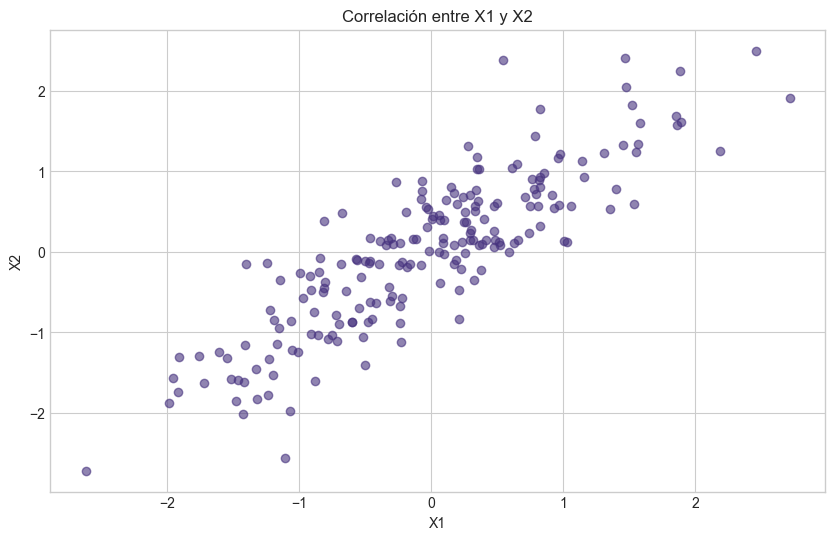

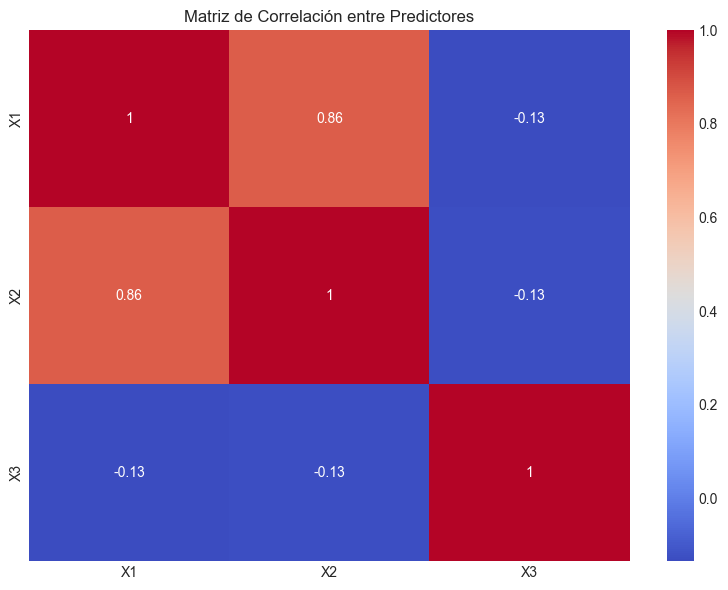

In [4]:
# Generamos datos con multicolinealidad
n = 200  # Número de observaciones
beta_real = np.array([3, 1.5, -2, 2.5])  # Coeficientes reales

# Generamos la primera variable independiente
X1 = np.random.normal(0, 1, n)

# Generamos la segunda variable con correlación alta con X1
X2 = 0.85 * X1 + np.random.normal(0, 0.5, n)

# Generamos variables adicionales
X3 = np.random.normal(0, 1, n)
X4 = np.random.normal(0, 1, n)

# Creamos el término de error
epsilon = np.random.normal(0, 1, n)

# Variable dependiente
y = beta_real[0] + beta_real[1] * X1 + beta_real[2] * X2 + beta_real[3] * X3 + epsilon

# Matriz de diseño
X = np.column_stack((np.ones(n), X1, X2, X3))

# Calculamos los coeficientes usando OLS
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Mostramos la matriz de correlación entre predictores
X_corr = np.column_stack((X1, X2, X3))
corr_matrix = np.corrcoef(X_corr.T)
print("Matriz de correlación:")
print(corr_matrix)
print("\nCorrelación entre X1 y X2:", np.corrcoef(X1, X2)[0, 1])

# Calculamos VIF para cada predictor
X_df = pd.DataFrame(X[:, 1:], columns=['X1', 'X2', 'X3'])
vif_data = pd.DataFrame()
vif_data["Variable"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

print("\nFactores de Inflación de la Varianza (VIF):")
print(vif_data)

# Calculamos y mostramos los coeficientes estimados vs reales
print("\nCoeficientes reales:", beta_real)
print("Coeficientes estimados:", beta_hat)

# Visualización de la correlación
plt.figure(figsize=(10, 6))
plt.scatter(X1, X2, alpha=0.6)
plt.title('Correlación entre X1 y X2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

# Matriz de correlación como heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=['X1', 'X2', 'X3'], yticklabels=['X1', 'X2', 'X3'])
plt.title('Matriz de Correlación entre Predictores')
plt.tight_layout()
plt.show()


## 2. Métodos de Preprocesamiento: Centrado y Estandarización

Una primera aproximación para reducir la multicolinealidad consiste en aplicar transformaciones a las variables predictoras antes de ajustar el modelo. Las dos transformaciones más comunes son el centrado y la estandarización.

### 2.1 Centrado de Variables

El centrado de variables implica restar la media a cada variable predictora:

$$X_{centrada} = X - \bar{X}$$

Donde $\bar{X}$ es la media de la variable $X$.

#### Efectos del Centrado:

1. **Reduce la correlación entre las variables originales y sus términos polinómicos o de interacción**. Por ejemplo, $X$ y $X^2$ suelen estar altamente correlacionados, pero $(X - \bar{X})$ y $(X - \bar{X})^2$ tienen menor correlación.

2. **Cambia la interpretación del intercepto**. Cuando las variables están centradas, el intercepto representa el valor esperado de $Y$ cuando todas las variables predictoras están en sus valores medios.

3. **No afecta la pendiente de las variables lineales**. Los coeficientes de regresión para los términos lineales no cambian con el centrado.

### 2.2 Estandarización de Variables

La estandarización combina el centrado con una normalización por la desviación estándar:

$$X_{estandarizada} = \frac{X - \bar{X}}{s_X}$$

Donde $s_X$ es la desviación estándar de la variable $X$.

#### Efectos de la Estandarización:

1. **Permite comparar la importancia relativa de los predictores**. Los coeficientes de un modelo con variables estandarizadas reflejan cuánto cambia $Y$ (en unidades de desviación estándar) cuando $X$ cambia en una desviación estándar.

2. **Ayuda a la convergencia de algoritmos iterativos**. Muchos algoritmos de optimización funcionan mejor cuando las variables tienen escalas similares.

3. **Es especialmente útil cuando las variables tienen unidades de medida muy diferentes**.

### 2.3 Impacto en la Multicolinealidad

Estas transformaciones pueden reducir la multicolinealidad en ciertos casos, especialmente cuando:

- Hay términos polinómicos o interacciones en el modelo
- Existen variables con diferentes escalas
- Se incluyen funciones trigonométricas o exponenciales de las variables

Sin embargo, es importante notar que el centrado y la estandarización **no resuelven la multicolinealidad causada por relaciones lineales inherentes entre los predictores originales**.


Matriz de correlación (datos originales):
                  X1        X2  X1_squared  X2_squared      X1X2
X1          1.000000 -0.025687    0.013376   -0.092462 -0.042736
X2         -0.025687  1.000000   -0.043694    0.043892 -0.074070
X1_squared  0.013376 -0.043694    1.000000    0.076440 -0.125006
X2_squared -0.092462  0.043892    0.076440    1.000000  0.080548
X1X2       -0.042736 -0.074070   -0.125006    0.080548  1.000000

VIF (datos originales):
   Variable       VIF
0         0  1.009861
1         1  1.011953
2         2  1.331988
3         3  1.320903
4         4  1.032055

Matriz de correlación (datos centrados):
                  X1        X2  X1_squared  X2_squared      X1X2
X1          1.000000 -0.025687    0.013376   -0.092462 -0.042736
X2         -0.025687  1.000000   -0.043694    0.043892 -0.074070
X1_squared  0.013376 -0.043694    1.000000    0.076440 -0.125006
X2_squared -0.092462  0.043892    0.076440    1.000000  0.080548
X1X2       -0.042736 -0.074070   -0.125006  

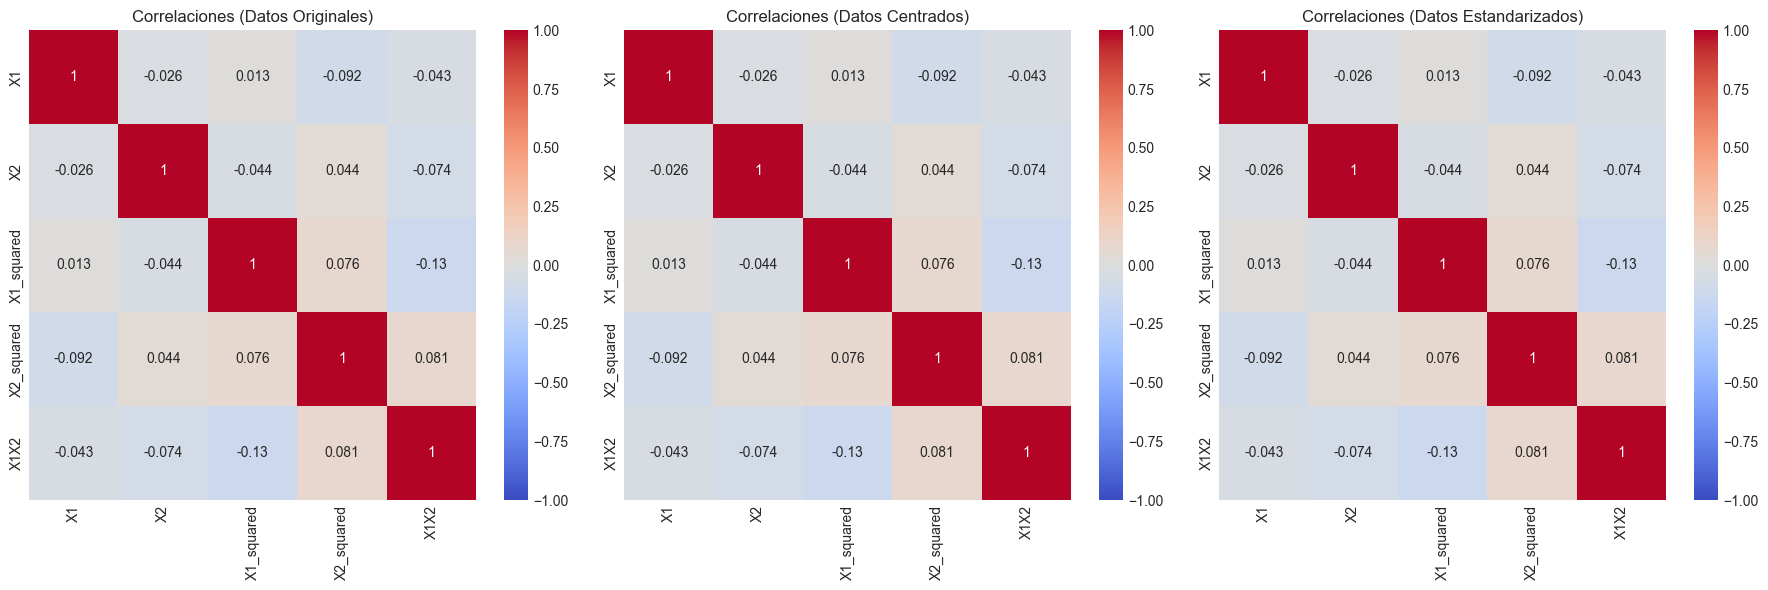


============= Modelo con Datos Originales =============
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0824      0.118     17.600      0.000       1.849       2.316
x1             0.5049      0.012     40.801      0.000       0.480       0.529
x2             0.7079      0.024     29.783      0.000       0.661       0.755
x3            -0.2978      0.002   -123.407      0.000      -0.303      -0.293
x4             0.1983      0.006     35.673      0.000       0.187       0.209
x5            -0.0995      0.004    -25.428      0.000      -0.107      -0.092

============= Modelo con Datos Centrados =============
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1298      0.072    -85.035      0.000      -6.272      -5.988
x1             0.5

In [5]:
# Implementación de centrado y estandarización con datos de ejemplo

# Función para calcular VIF
def calcular_vif(X):
    """Calcula el VIF para cada variable en X."""
    vif_data = pd.DataFrame()
    vif_data["Variable"] = range(X.shape[1])
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data

# Generamos datos con términos polinómicos
n = 200
X1 = np.random.uniform(-10, 10, n)
X2 = np.random.normal(0, 3, n)

# Creamos términos polinómicos
X1_squared = X1**2
X2_squared = X2**2
X1X2 = X1 * X2

# Variable dependiente
y = 2 + 0.5*X1 - 0.3*X1_squared + 0.7*X2 + 0.2*X2_squared - 0.1*X1X2 + np.random.normal(0, 1, n)

# Creamos DataFrame para mejor visualización
df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X1_squared': X1_squared,
    'X2_squared': X2_squared,
    'X1X2': X1X2,
    'y': y
})

# Analizamos correlaciones en los datos originales
corr_original = df.iloc[:, :-1].corr()
print("Matriz de correlación (datos originales):")
print(corr_original)

# Matriz de diseño para el cálculo de VIF (sin intercepto)
X_original = df.iloc[:, :-1].values
# Calculamos VIF para datos originales
print("\nVIF (datos originales):")
print(calcular_vif(X_original))

# Centrado de variables
df_centered = df.copy()
for col in df.columns[:-1]:  # Excluimos la variable dependiente
    df_centered[col] = df[col] - df[col].mean()

# Analizamos correlaciones después del centrado
corr_centered = df_centered.iloc[:, :-1].corr()
print("\nMatriz de correlación (datos centrados):")
print(corr_centered)

# Matriz de diseño centrada para el cálculo de VIF
X_centered = df_centered.iloc[:, :-1].values
# Calculamos VIF para datos centrados
print("\nVIF (datos centrados):")
print(calcular_vif(X_centered))

# Estandarización de variables
scaler = StandardScaler()
X_std = scaler.fit_transform(df.iloc[:, :-1])
df_std = pd.DataFrame(X_std, columns=df.columns[:-1])
df_std['y'] = df['y']  # Mantenemos y sin transformar

# Analizamos correlaciones después de la estandarización
corr_std = df_std.iloc[:, :-1].corr()
print("\nMatriz de correlación (datos estandarizados):")
print(corr_std)

# Calculamos VIF para datos estandarizados
print("\nVIF (datos estandarizados):")
print(calcular_vif(X_std))

# Visualización de las correlaciones con heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(corr_original, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Correlaciones (Datos Originales)')

sns.heatmap(corr_centered, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Correlaciones (Datos Centrados)')

sns.heatmap(corr_std, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[2])
axes[2].set_title('Correlaciones (Datos Estandarizados)')

plt.tight_layout()
plt.show()

# Ajustamos modelos con los diferentes conjuntos de datos y comparamos 
# los coeficientes y sus errores estándar

# Modelo 1: Datos originales
X_orig_with_const = sm.add_constant(X_original)
model_orig = sm.OLS(y, X_orig_with_const).fit()

# Modelo 2: Datos centrados
X_cent_with_const = sm.add_constant(X_centered)
model_cent = sm.OLS(y, X_cent_with_const).fit()

# Modelo 3: Datos estandarizados
X_std_with_const = sm.add_constant(X_std)
model_std = sm.OLS(y, X_std_with_const).fit()

# Comparamos resultados
print("\n============= Modelo con Datos Originales =============")
print(model_orig.summary().tables[1])

print("\n============= Modelo con Datos Centrados =============")
print(model_cent.summary().tables[1])

print("\n============= Modelo con Datos Estandarizados =============")
print(model_std.summary().tables[1])


## 3. Métodos de Regularización

El centrado y la estandarización pueden ayudar en algunos casos, pero para abordar realmente la multicolinealidad, las técnicas de regularización ofrecen soluciones más robustas. La regularización introduce un término de penalización en la función objetivo, lo que limita el crecimiento excesivo de los coeficientes y estabiliza las estimaciones.

### 3.1 Regresión Ridge (L2)

La regresión Ridge minimiza la siguiente función objetivo:

$$J(\beta) = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p}\beta_j^2$$

Donde $\lambda \geq 0$ es el parámetro de regularización que controla la fuerza de la penalización.

#### Características de Ridge:

1. **Shrinkage (contracción)**: Ridge contrae los coeficientes hacia cero, pero nunca los hace exactamente cero.

2. **Solución analítica**: $\hat{\beta}_{Ridge} = (X^TX + \lambda I)^{-1}X^Ty$, donde $I$ es la matriz identidad.

3. **Estabilidad numérica**: La adición de $\lambda I$ a $X^TX$ hace que la matriz resultante sea siempre invertible, incluso en presencia de multicolinealidad perfecta.

4. **Mejor cuando todos los predictores son relevantes**: Ridge funciona mejor cuando la mayoría de las variables aportan información útil al modelo.

### 3.2 Regresión Lasso (L1)

La regresión Lasso (Least Absolute Shrinkage and Selection Operator) minimiza:

$$J(\beta) = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p}|\beta_j|$$

La diferencia con Ridge está en la forma de la penalización: Lasso usa la norma L1 (suma de valores absolutos) en lugar de la norma L2 (suma de cuadrados).

#### Características de Lasso:

1. **Selección de variables**: Lasso puede reducir coeficientes exactamente a cero, realizando así una selección automática de variables.

2. **Sin solución analítica**: Debido a la no diferenciabilidad de la norma L1, Lasso requiere algoritmos iterativos para su solución.

3. **Mejor cuando hay muchas variables irrelevantes**: Lasso es particularmente útil cuando se espera que muchas variables no aporten información al modelo.

### 3.3 Elastic Net

Elastic Net combina las penalizaciones de Ridge y Lasso:

$$J(\beta) = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_j x_{ij})^2 + \lambda_1 \sum_{j=1}^{p}|\beta_j| + \lambda_2 \sum_{j=1}^{p}\beta_j^2$$

O, alternativamente, con un parámetro de mezcla $\alpha \in [0,1]$:

$$J(\beta) = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_j x_{ij})^2 + \lambda \left( \alpha \sum_{j=1}^{p}|\beta_j| + (1-\alpha) \sum_{j=1}^{p}\beta_j^2 \right)$$

Donde $\alpha = 0$ corresponde a Ridge y $\alpha = 1$ a Lasso.

#### Características de Elastic Net:

1. **Selección de grupos de variables correlacionadas**: A diferencia de Lasso, que tiende a seleccionar una variable de cada grupo correlacionado, Elastic Net puede seleccionar grupos completos.

2. **Combina las ventajas de Ridge y Lasso**: Realiza selección de variables (como Lasso) y maneja bien grupos de variables correlacionadas (como Ridge).

3. **Dos hiperparámetros**: Requiere ajustar tanto $\lambda$ (la fuerza total de la regularización) como $\alpha$ (la proporción entre L1 y L2).

### 3.4 Comparación de los Métodos de Regularización

| Método | Penalización | Selección de Variables | Manejo de Correlaciones | Solución |
|--------|--------------|------------------------|------------------------|----------|
| Ridge | L2 (cuadrática) | No | Contrae coeficientes de variables correlacionadas hacia valores similares | Analítica |
| Lasso | L1 (absoluta) | Sí | Tiende a seleccionar una variable de cada grupo correlacionado | Iterativa |
| Elastic Net | Combinación L1 y L2 | Sí | Puede seleccionar grupos completos de variables correlacionadas | Iterativa |


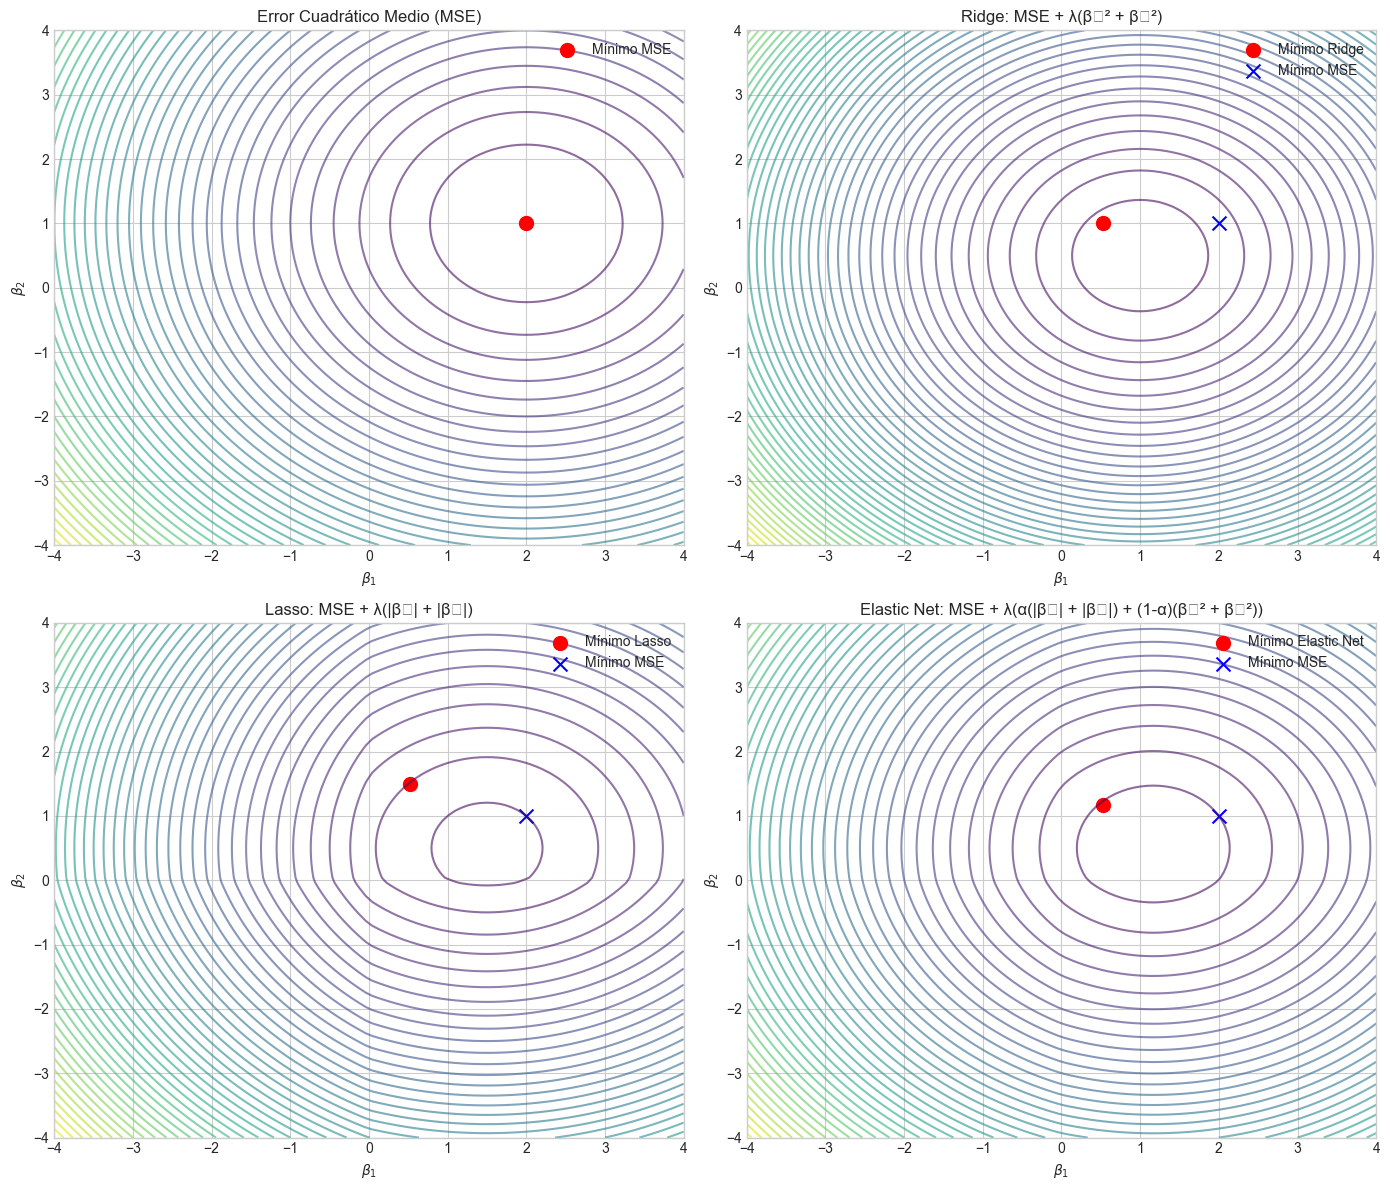

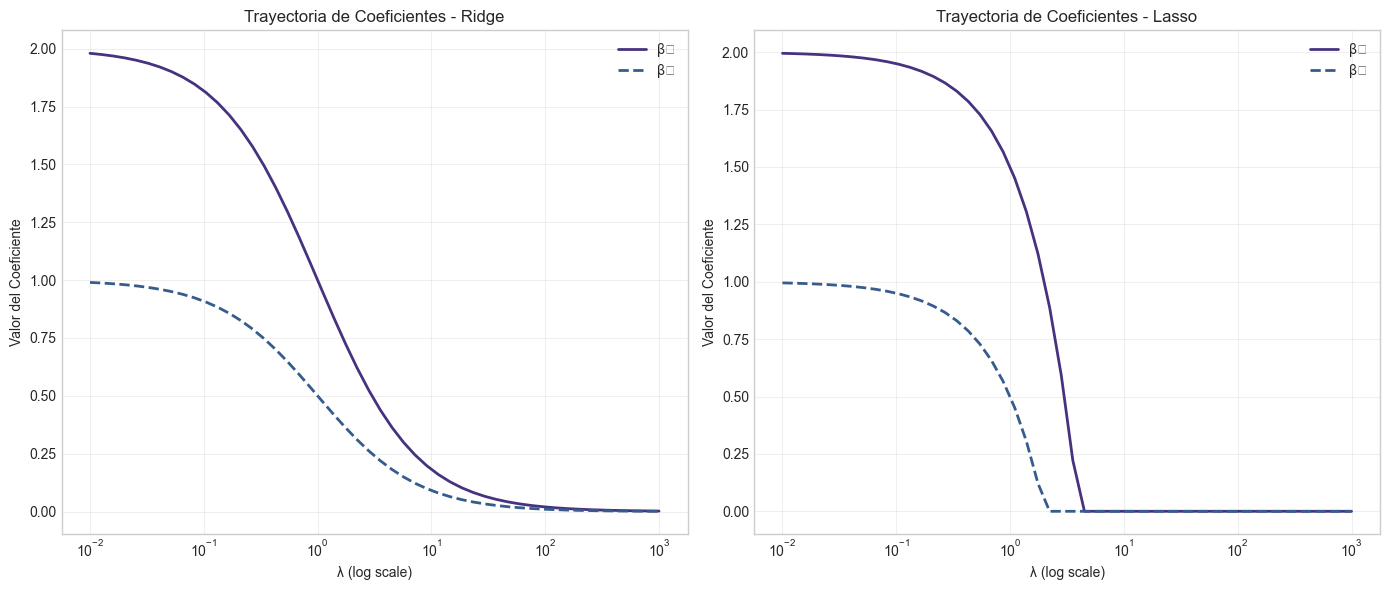

In [6]:
# Visualización conceptual de las penalizaciones Ridge y Lasso

# Función para generar contornos de la función de pérdida
def plot_contours(ax, func, xlim=(-4, 4), ylim=(-4, 4), nlevels=50, **params):
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y, **params)
    CS = ax.contour(X, Y, Z, levels=nlevels, cmap='viridis', alpha=0.6)
    ax.set_xlabel(r'$\beta_1$')
    ax.set_ylabel(r'$\beta_2$')
    return CS

# Funciones de pérdida para Ridge y Lasso
def ridge_penalty(x, y, lambda_value=1.0):
    return lambda_value * (x**2 + y**2)

def lasso_penalty(x, y, lambda_value=1.0):
    return lambda_value * (np.abs(x) + np.abs(y))

def elastic_net_penalty(x, y, lambda_value=1.0, alpha=0.5):
    return lambda_value * (alpha * (np.abs(x) + np.abs(y)) + (1 - alpha) * (x**2 + y**2))

def mse_contours(x, y):
    # Simulamos contornos de la función de pérdida MSE
    return (x - 2)**2 + (y - 1)**2

# Creamos la figura
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Contornos de la función de pérdida MSE (sin regularización)
plot_contours(axes[0, 0], mse_contours)
axes[0, 0].scatter(2, 1, color='red', marker='o', s=100, label='Mínimo MSE')
axes[0, 0].set_title('Error Cuadrático Medio (MSE)')
axes[0, 0].legend()

# Contornos de Ridge
# Combinación de MSE + Ridge penalty
def mse_ridge(x, y, lambda_value=1.0):
    return mse_contours(x, y) + ridge_penalty(x, y, lambda_value)

contours = plot_contours(axes[0, 1], mse_ridge, lambda_value=1.0)
min_idx = np.unravel_index(np.argmin(mse_ridge(np.linspace(-4, 4, 100)[:, None], 
                                           np.linspace(-4, 4, 100)[None, :], 
                                           lambda_value=1.0)), 
                           (100, 100))
min_x = np.linspace(-4, 4, 100)[min_idx[1]]
min_y = np.linspace(-4, 4, 100)[min_idx[0]]
axes[0, 1].scatter(min_x, min_y, color='red', marker='o', s=100, label='Mínimo Ridge')
axes[0, 1].scatter(2, 1, color='blue', marker='x', s=100, label='Mínimo MSE')
axes[0, 1].set_title('Ridge: MSE + λ(β₁² + β₂²)')
axes[0, 1].legend()

# Contornos de Lasso
# Combinación de MSE + Lasso penalty
def mse_lasso(x, y, lambda_value=1.0):
    return mse_contours(x, y) + lasso_penalty(x, y, lambda_value)

contours = plot_contours(axes[1, 0], mse_lasso, lambda_value=1.0)
min_idx = np.unravel_index(np.argmin(mse_lasso(np.linspace(-4, 4, 100)[:, None], 
                                           np.linspace(-4, 4, 100)[None, :], 
                                           lambda_value=1.0)), 
                           (100, 100))
min_x = np.linspace(-4, 4, 100)[min_idx[1]]
min_y = np.linspace(-4, 4, 100)[min_idx[0]]
axes[1, 0].scatter(min_x, min_y, color='red', marker='o', s=100, label='Mínimo Lasso')
axes[1, 0].scatter(2, 1, color='blue', marker='x', s=100, label='Mínimo MSE')
axes[1, 0].set_title('Lasso: MSE + λ(|β₁| + |β₂|)')
axes[1, 0].legend()

# Contornos de Elastic Net
# Combinación de MSE + Elastic Net penalty
def mse_elastic_net(x, y, lambda_value=1.0, alpha=0.5):
    return mse_contours(x, y) + elastic_net_penalty(x, y, lambda_value, alpha)

contours = plot_contours(axes[1, 1], mse_elastic_net, lambda_value=1.0, alpha=0.5)
min_idx = np.unravel_index(np.argmin(mse_elastic_net(np.linspace(-4, 4, 100)[:, None], 
                                               np.linspace(-4, 4, 100)[None, :], 
                                               lambda_value=1.0, alpha=0.5)), 
                           (100, 100))
min_x = np.linspace(-4, 4, 100)[min_idx[1]]
min_y = np.linspace(-4, 4, 100)[min_idx[0]]
axes[1, 1].scatter(min_x, min_y, color='red', marker='o', s=100, label='Mínimo Elastic Net')
axes[1, 1].scatter(2, 1, color='blue', marker='x', s=100, label='Mínimo MSE')
axes[1, 1].set_title('Elastic Net: MSE + λ(α(|β₁| + |β₂|) + (1-α)(β₁² + β₂²))')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Visualización del efecto de lambda en las trayectorias de coeficientes
# Simulamos coeficientes Ridge y Lasso para distintos valores de lambda
lambdas = np.logspace(-2, 3, 50)
beta1_ridge = 2 / (1 + lambdas)
beta2_ridge = 1 / (1 + lambdas)
beta1_lasso = np.maximum(0, 2 - lambdas/2)
beta2_lasso = np.maximum(0, 1 - lambdas/2)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lambdas, beta1_ridge, '-', linewidth=2, label='β₁')
plt.plot(lambdas, beta2_ridge, '--', linewidth=2, label='β₂')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('Valor del Coeficiente')
plt.title('Trayectoria de Coeficientes - Ridge')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lambdas, beta1_lasso, '-', linewidth=2, label='β₁')
plt.plot(lambdas, beta2_lasso, '--', linewidth=2, label='β₂')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('Valor del Coeficiente')
plt.title('Trayectoria de Coeficientes - Lasso')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


## 4. Implementación desde Cero

### 4.1 Implementación de Regresión Ridge

Implementaremos la regresión Ridge utilizando la fórmula analítica:

$$\hat{\beta}_{Ridge} = (X^TX + \lambda I)^{-1}X^Ty$$


Coeficientes verdaderos (sin intercepto):
[ 3.5 -2.   1.   0.   0.   0.   0.   0.   0.   0. ]

Estimación OLS (el primer valor es el intercepto):
[ 0.23276971  4.75191129 -2.26481809  0.87284076 -1.18159354  0.35782312
 -0.06174291  0.15548808  0.13255416 -0.14652924 -0.2044695 ]

Estimaciones Ridge para diferentes valores de lambda:
Lambda = 0.001:
[ 0.23271534  4.74558624 -2.26046759  0.87274618 -1.17533075  0.35352046
 -0.06174468  0.15538548  0.13268257 -0.14668888 -0.20437727]
Lambda = 0.01:
[ 0.23223827  4.68986901 -2.22249608  0.87191636 -1.12016622  0.31597208
 -0.06175803  0.1544898   0.13381563 -0.14808783 -0.20356749]
Lambda = 0.1:
[ 0.22844356  4.23055041 -1.93259051  0.86527056 -0.66577562  0.02969549
 -0.06171383  0.1476434   0.1432864  -0.15913307 -0.19705989]
Lambda = 1.0:
[ 0.21936235  2.72188564 -1.2277303   0.84205568  0.81057107 -0.65871516
 -0.05876266  0.1313502   0.17641914 -0.18947905 -0.17706263]
Lambda = 10.0:
[ 0.24880937  1.77897565 -0.93664948  0.76857938  

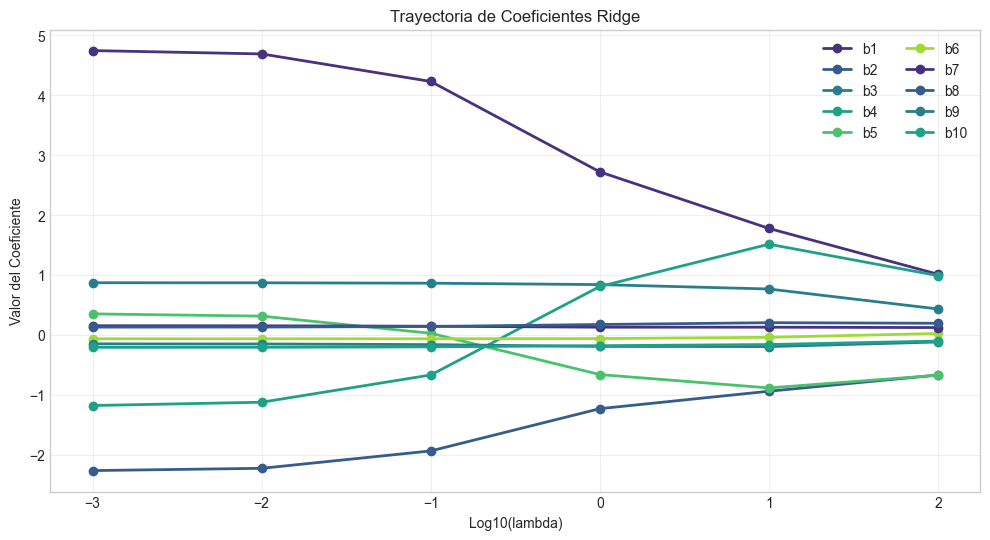

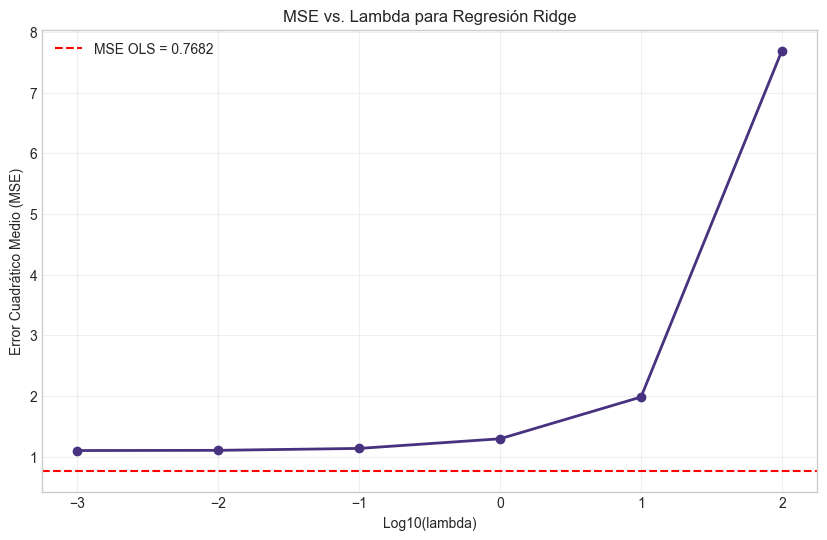

In [8]:

def ridge_regression(X, y, lambda_value=1.0):
    """
    Implementación de Regresión Ridge desde cero.

    Parámetros:
    X : array-like, matriz de diseño (con intercepto como primera columna si se desea)
    y : array-like, vector de variable respuesta
    lambda_value : float, parámetro de regularización

    Retorna:
    beta_ridge : array, coeficientes estimados
    """
    n_samples, n_features = X.shape

    # Crear matriz de penalización (matriz identidad)
    # Nota: No penalizamos el intercepto, por lo que la primera posición es 0
    penalty = np.identity(n_features)
    if X[:, 0].mean() == 1:  # Verificamos si la primera columna es el intercepto
        penalty[0, 0] = 0  # No penalizamos el intercepto

    # Calcular los coeficientes Ridge
    XtX = X.T @ X
    Xty = X.T @ y

    # Fórmula de Ridge: (X^T*X + lambda*I)^(-1) * X^T*y
    beta_ridge = np.linalg.inv(XtX + lambda_value * penalty) @ Xty

    return beta_ridge

# Probamos nuestra implementación con datos sintéticos
np.random.seed(42)
n = 100
p = 10  # Número de predictores

# Generamos datos con multicolinealidad
X_true = np.random.normal(0, 1, size=(n, 3))
X_noisy = X_true[:, 0:2] + np.random.normal(0, 0.1, size=(n, 2))  # Variables correlacionadas
X_random = np.random.normal(0, 1, size=(n, p-5))  # Variables aleatorias adicionales
X_data = np.hstack((X_true, X_noisy, X_random))

# Coeficientes verdaderos: solo los primeros 3 tienen impacto real
beta_true = np.zeros(p)
beta_true[:3] = [3.5, -2.0, 1.0]

# Variable respuesta con ruido
y = X_data @ beta_true + np.random.normal(0, 1, n)

# Añadimos columna de intercepto
X_with_intercept = np.column_stack((np.ones(n), X_data))

# Ajustamos modelo OLS
beta_ols = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y

# Probamos diferentes valores de lambda para Ridge
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
betas_ridge = []

for lambda_val in lambdas:
    beta_ridge = ridge_regression(X_with_intercept, y, lambda_val)
    betas_ridge.append(beta_ridge)

# Comparamos resultados
print("Coeficientes verdaderos (sin intercepto):")
print(beta_true)

print("\nEstimación OLS (el primer valor es el intercepto):")
print(beta_ols)

print("\nEstimaciones Ridge para diferentes valores de lambda:")
for i, lambda_val in enumerate(lambdas):
    print(f"Lambda = {lambda_val}:")
    print(betas_ridge[i])

# Visualizamos la trayectoria de los coeficientes
plt.figure(figsize=(12, 6))
coef_names = [f'b{i}' for i in range(len(beta_ols))]
coef_paths = np.array(betas_ridge).T  # Transponer para facilitar el plotting

for i in range(1, coef_paths.shape[0]):  # Saltamos el intercepto
    plt.plot(np.log10(lambdas), coef_paths[i], '-o', linewidth=2, label=coef_names[i])

plt.xlabel('Log10(lambda)')
plt.ylabel('Valor del Coeficiente')
plt.title('Trayectoria de Coeficientes Ridge')
plt.legend(loc='best', ncol=2)
plt.grid(True, alpha=0.3)
plt.show()

# Calculamos métricas para evaluar el rendimiento
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Dividimos datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_with_intercept, y, test_size=0.3, random_state=42)

# Evaluamos rendimiento de OLS
y_pred_ols = X_test @ beta_ols
mse_ols = mean_squared_error(y_test, y_pred_ols)

# Evaluamos rendimiento de Ridge con diferentes lambdas
mse_ridge = []
for lambda_val in lambdas:
    beta_ridge = ridge_regression(X_train, y_train, lambda_val)
    y_pred_ridge = X_test @ beta_ridge
    mse_ridge.append(mean_squared_error(y_test, y_pred_ridge))

# Visualizamos MSE vs lambda
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambdas), mse_ridge, 'o-', linewidth=2)
plt.axhline(y=mse_ols, color='r', linestyle='--', label=f'MSE OLS = {mse_ols:.4f}')
plt.xlabel('Log10(lambda)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE vs. Lambda para Regresión Ridge')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 4.2 Implementación de Regresión Lasso y Elastic Net

A diferencia de Ridge, Lasso no tiene una solución analítica y requiere métodos iterativos. Implementaremos Lasso y Elastic Net utilizando el método de descenso por coordenadas.


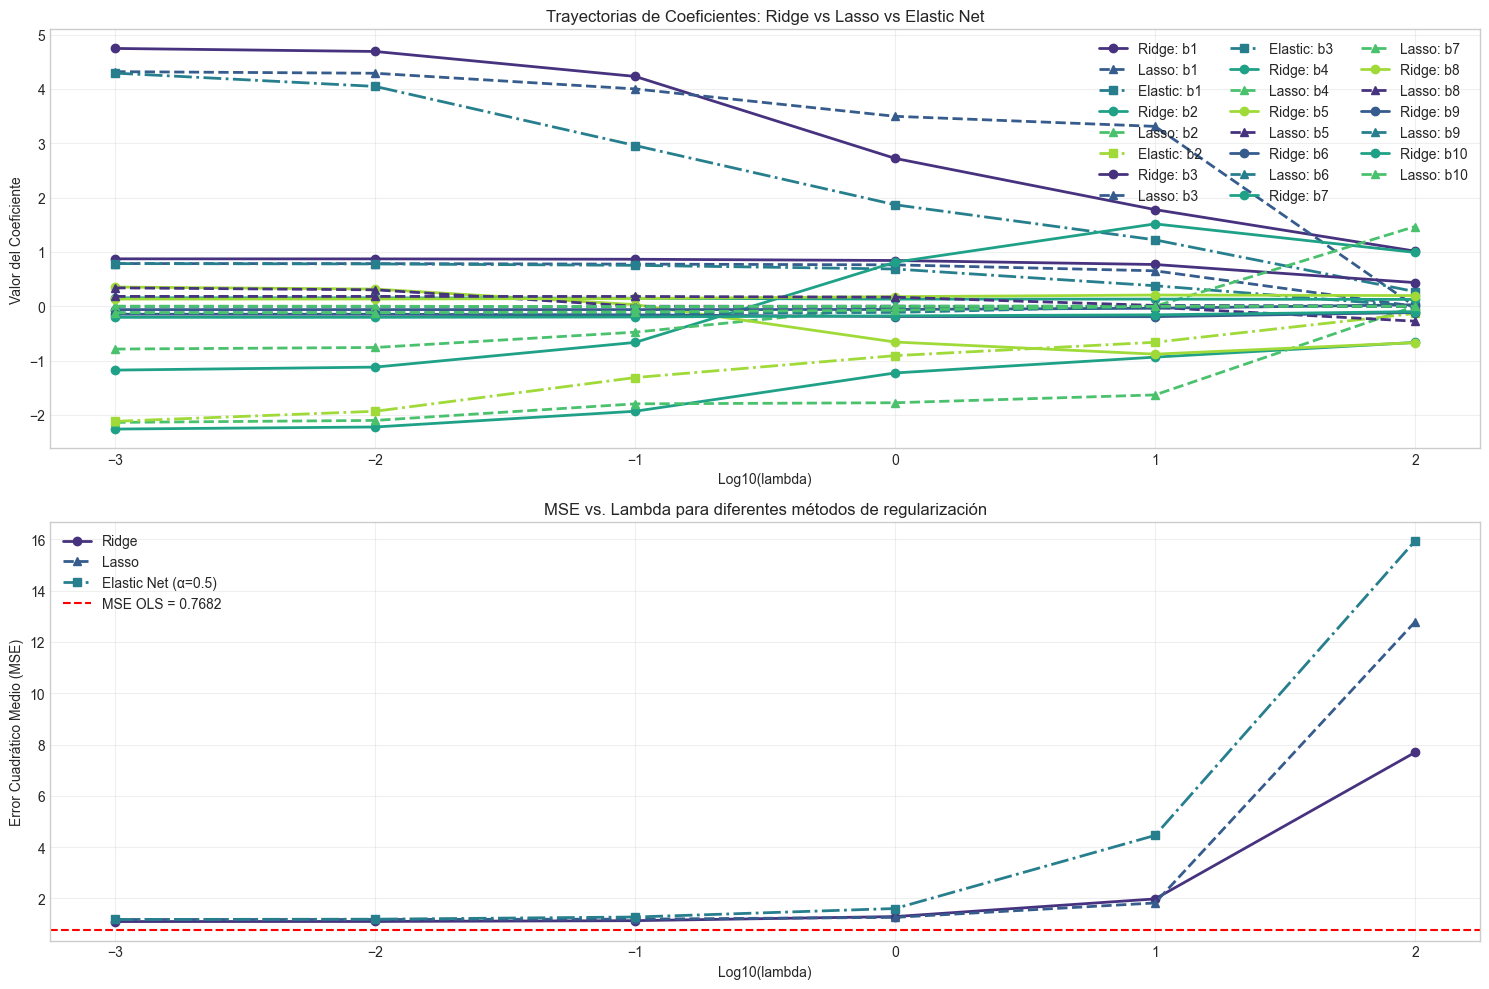

In [9]:

def soft_threshold(x, lambda_val):
    """
    Función de umbral suave utilizada en el algoritmo de coordenadas para Lasso.

    Parámetros:
    x : float, valor a umbralizar
    lambda_val : float, parámetro de umbralización

    Retorna:
    float, valor umbralizado
    """
    if x > lambda_val:
        return x - lambda_val
    elif x < -lambda_val:
        return x + lambda_val
    else:
        return 0

def lasso_coordinate_descent(X, y, lambda_value=1.0, max_iter=1000, tol=1e-4):
    """
    Implementación de Regresión Lasso mediante descenso por coordenadas.

    Parámetros:
    X : array-like, matriz de diseño (con intercepto como primera columna si se desea)
    y : array-like, vector de variable respuesta
    lambda_value : float, parámetro de regularización
    max_iter : int, número máximo de iteraciones
    tol : float, tolerancia para convergencia

    Retorna:
    beta_lasso : array, coeficientes estimados
    """
    n_samples, n_features = X.shape

    # Inicializamos coeficientes en cero
    beta = np.zeros(n_features)

    # Escalamos X para que cada columna tenga norma L2=1 (excepto intercepto)
    # Nota: Esto es importante para la convergencia del algoritmo
    norms = np.sqrt(np.sum(X**2, axis=0))
    if X[:, 0].mean() == 1:  # Si la primera columna es el intercepto
        norms[0] = 1.0  # No escalamos el intercepto
    X_scaled = X / norms

    # Valores de ajuste previos para verificar convergencia
    old_beta = np.copy(beta)

    # Ciclo principal
    for iteration in range(max_iter):
        # Guardamos los coeficientes de la iteración anterior
        old_beta = np.copy(beta)

        # Iteramos sobre cada coeficiente
        for j in range(n_features):
            # Si es intercepto, no aplicamos regularización
            if j == 0 and X[:, 0].mean() == 1:
                continue

            # Calculamos la predicción con todos los coeficientes excepto j
            beta[j] = 0  # Temporalmente establecemos beta_j a cero
            y_pred = X_scaled @ beta

            # Calculamos el residual parcial (lo que no es explicado por otras variables)
            r_j = y - y_pred

            # Correlación de la variable j con el residual
            corr = X_scaled[:, j] @ r_j

            # Aplicamos umbral suave
            lambda_scaled = lambda_value / norms[j]
            beta[j] = soft_threshold(corr, lambda_scaled)

        # Verificamos convergencia
        if np.linalg.norm(beta - old_beta) < tol:
            break

    # Reescalamos los coeficientes
    beta = beta / norms

    return beta

def elastic_net_coordinate_descent(X, y, lambda_value=1.0, alpha=0.5, max_iter=1000, tol=1e-4):
    """
    Implementación de Elastic Net mediante descenso por coordenadas.

    Parámetros:
    X : array-like, matriz de diseño (con intercepto como primera columna si se desea)
    y : array-like, vector de variable respuesta
    lambda_value : float, parámetro de regularización global
    alpha : float, parámetro de mezcla entre Lasso y Ridge (alpha=1 es Lasso, alpha=0 es Ridge)
    max_iter : int, número máximo de iteraciones
    tol : float, tolerancia para convergencia

    Retorna:
    beta_elastic : array, coeficientes estimados
    """
    n_samples, n_features = X.shape

    # Inicializamos coeficientes en cero
    beta = np.zeros(n_features)

    # Escalamos X para que cada columna tenga norma L2=1 (excepto intercepto)
    norms = np.sqrt(np.sum(X**2, axis=0))
    if X[:, 0].mean() == 1:  # Si la primera columna es el intercepto
        norms[0] = 1.0  # No escalamos el intercepto
    X_scaled = X / norms

    # Valores de ajuste previos para verificar convergencia
    old_beta = np.copy(beta)

    # Ciclo principal
    for iteration in range(max_iter):
        # Guardamos los coeficientes de la iteración anterior
        old_beta = np.copy(beta)

        # Iteramos sobre cada coeficiente
        for j in range(n_features):
            # Si es intercepto, no aplicamos regularización
            if j == 0 and X[:, 0].mean() == 1:
                continue

            # Calculamos la predicción con todos los coeficientes excepto j
            old_beta_j = beta[j]
            beta[j] = 0  # Temporalmente establecemos beta_j a cero
            y_pred = X_scaled @ beta

            # Calculamos el residual parcial
            r_j = y - y_pred

            # Correlación de la variable j con el residual
            corr = X_scaled[:, j] @ r_j

            # Fórmula para Elastic Net:
            # La parte Ridge (L2) modifica el coeficiente antes del umbral suave (L1)
            lambda_l1 = lambda_value * alpha / norms[j]
            lambda_l2 = lambda_value * (1 - alpha) / norms[j]

            # Aplicamos umbral suave con ajuste por la parte Ridge
            if corr > lambda_l1:
                beta[j] = (corr - lambda_l1) / (1 + lambda_l2)
            elif corr < -lambda_l1:
                beta[j] = (corr + lambda_l1) / (1 + lambda_l2)
            else:
                beta[j] = 0

        # Verificamos convergencia
        if np.linalg.norm(beta - old_beta) < tol:
            break

    # Reescalamos los coeficientes
    beta = beta / norms

    return beta

# Probamos nuestras implementaciones con los mismos datos sintéticos

# Ajustamos Lasso para diferentes valores de lambda
betas_lasso = []
for lambda_val in lambdas:
    beta_lasso = lasso_coordinate_descent(X_train, y_train, lambda_val)
    betas_lasso.append(beta_lasso)

# Ajustamos Elastic Net con alpha=0.5 para diferentes valores de lambda
betas_elastic = []
for lambda_val in lambdas:
    beta_elastic = elastic_net_coordinate_descent(X_train, y_train, lambda_val, alpha=0.5)
    betas_elastic.append(beta_elastic)

# Evaluamos rendimiento de Lasso
mse_lasso = []
for i, lambda_val in enumerate(lambdas):
    y_pred_lasso = X_test @ betas_lasso[i]
    mse_lasso.append(mean_squared_error(y_test, y_pred_lasso))

# Evaluamos rendimiento de Elastic Net
mse_elastic = []
for i, lambda_val in enumerate(lambdas):
    y_pred_elastic = X_test @ betas_elastic[i]
    mse_elastic.append(mean_squared_error(y_test, y_pred_elastic))

# Visualizamos las trayectorias de coeficientes y MSE para los tres métodos
plt.figure(figsize=(15, 10))

# Trayectorias de coeficientes
plt.subplot(2, 1, 1)
coef_paths_lasso = np.array(betas_lasso).T
coef_paths_elastic = np.array(betas_elastic).T

for i in range(1, coef_paths.shape[0]):  # Saltamos el intercepto
    plt.plot(np.log10(lambdas), coef_paths[i], '-o', linewidth=2, label=f'Ridge: {coef_names[i]}')
    plt.plot(np.log10(lambdas), coef_paths_lasso[i], '--^', linewidth=2, label=f'Lasso: {coef_names[i]}')
    if i < 4:  # Mostramos solo algunos coeficientes para claridad
        plt.plot(np.log10(lambdas), coef_paths_elastic[i], '-.s', linewidth=2, label=f'Elastic: {coef_names[i]}')

plt.xlabel('Log10(lambda)')
plt.ylabel('Valor del Coeficiente')
plt.title('Trayectorias de Coeficientes: Ridge vs Lasso vs Elastic Net')
plt.legend(loc='best', ncol=3)
plt.grid(True, alpha=0.3)

# MSE vs lambda
plt.subplot(2, 1, 2)
plt.plot(np.log10(lambdas), mse_ridge, 'o-', linewidth=2, label='Ridge')
plt.plot(np.log10(lambdas), mse_lasso, '^--', linewidth=2, label='Lasso')
plt.plot(np.log10(lambdas), mse_elastic, 's-.', linewidth=2, label='Elastic Net (α=0.5)')
plt.axhline(y=mse_ols, color='r', linestyle='--', label=f'MSE OLS = {mse_ols:.4f}')
plt.xlabel('Log10(lambda)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE vs. Lambda para diferentes métodos de regularización')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Caso Práctico con Conjunto de Datos Real

Aplicaremos las técnicas aprendidas a un conjunto de datos real: el dataset de "California Housing", que contiene información sobre precios de viviendas y diversas características en diferentes bloques censales de California.

Información del dataset:
Número de muestras: 20640
Número de características: 8
Nombres de características: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


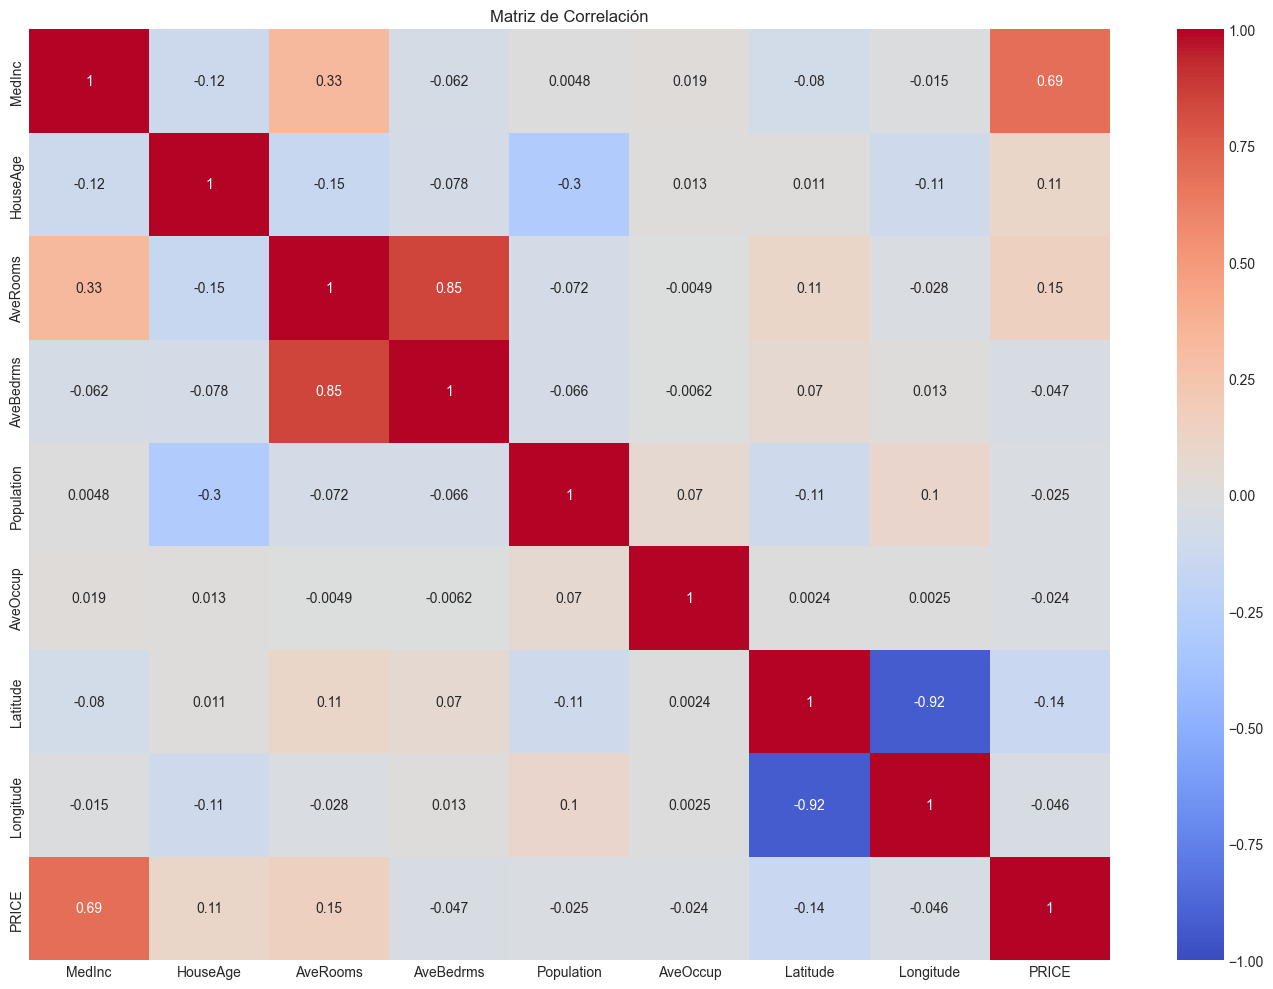

Factores de Inflación de la Varianza (VIF):
      Feature         VIF
7   Longitude  633.711654
6    Latitude  559.874071
2    AveRooms   45.993601
3   AveBedrms   43.590314
0      MedInc   11.511140
1    HouseAge    7.195917
4  Population    2.935745
5    AveOccup    1.095243

Resumen del modelo OLS:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.0562      0.779    -47.577      0.000     -38.583     -35.530
x1             0.4458      0.005     89.283      0.000       0.436       0.456
x2             0.0097      0.001     18.240      0.000       0.009       0.011
x3            -0.1221      0.007    -17.362      0.000      -0.136      -0.108
x4             0.7786      0.035     21.978      0.000       0.709       0.848
x5         -7.757e-07   5.63e-06     -0.138      0.890   -1.18e-05    1.03e-05
x6            -0.0034      0.000     -6.889      0.000      -0.00

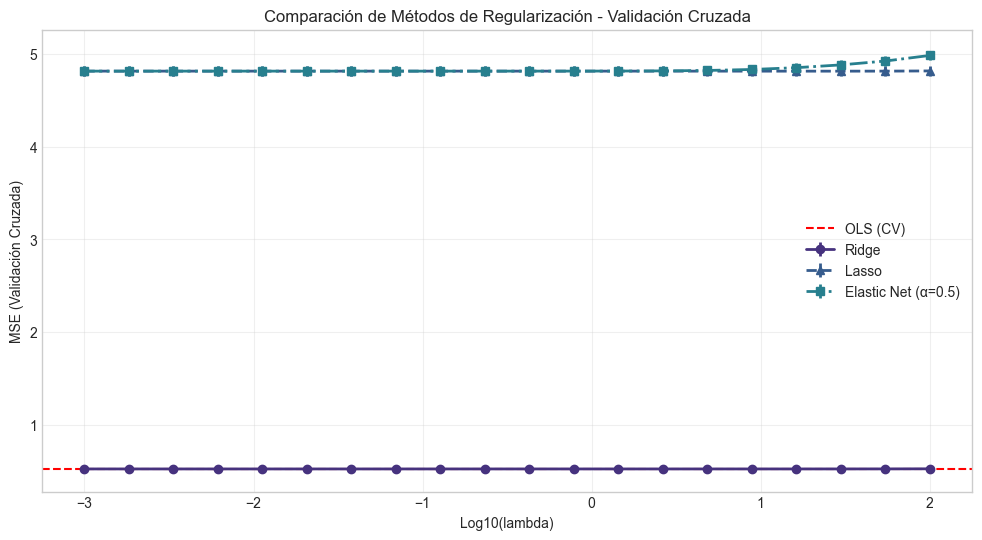

Mejor lambda para Ridge: 4.832930
Mejor lambda para Lasso: 29.763514
Mejor lambda para Elastic Net: 0.069519

Resultados en el conjunto de prueba:
MSE Ridge: 0.5305, R²: 0.5959
MSE Lasso: 4.8057, R²: -2.6613
MSE Elastic Net: 4.8070, R²: -2.6624
MSE OLS: 0.5306, R²: 0.5958

Comparación de coeficientes:
      Feature           OLS     Ridge     Lasso  Elastic_Net
0   Intercept -3.705624e+01  2.069240  0.000000     0.000000
1      MedInc  4.458226e-01  0.848884  0.838041     0.848919
2    HouseAge  9.681868e-03  0.122548  0.123200     0.122493
3    AveRooms -1.220951e-01 -0.298355 -0.271045    -0.298488
4   AveBedrms  7.785996e-01  0.346927  0.319643     0.347097
5  Population -7.757404e-07 -0.000739  0.000000    -0.000755
6    AveOccup -3.370027e-03 -0.041719 -0.039595    -0.041714
7    Latitude -4.185367e-01 -0.889753 -0.872361    -0.890277
8   Longitude -4.336880e-01 -0.864456 -0.845576    -0.864986


<Figure size 1400x800 with 0 Axes>

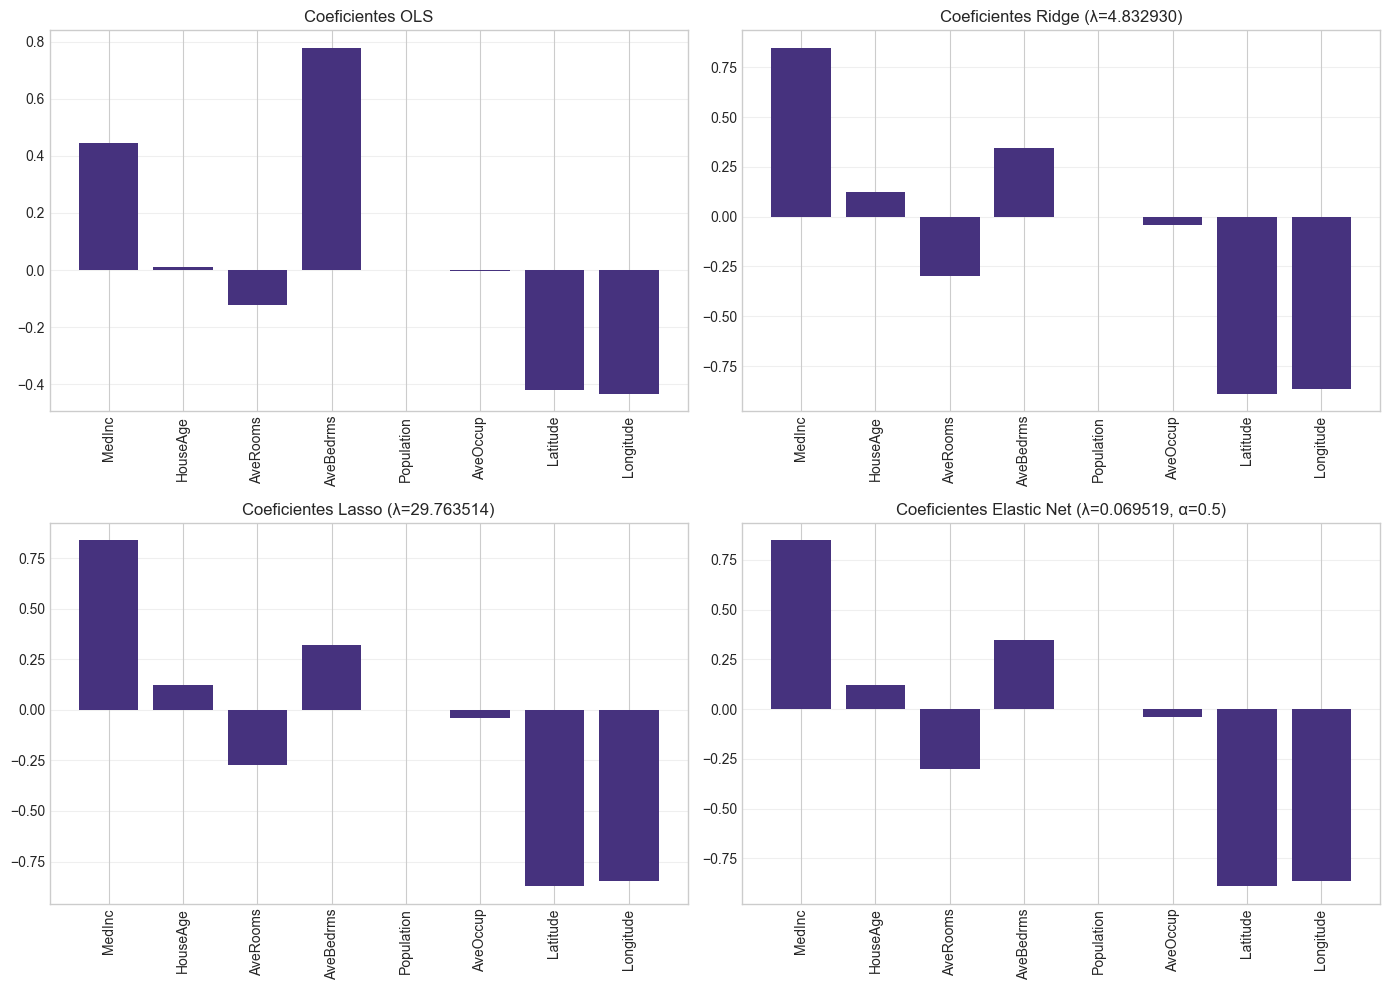


Selección de variables (número de coeficientes no cero, excluyendo intercepto):
OLS: 7 de 8
Ridge: 8 de 8
Lasso: 7 de 8
Elastic Net: 8 de 8


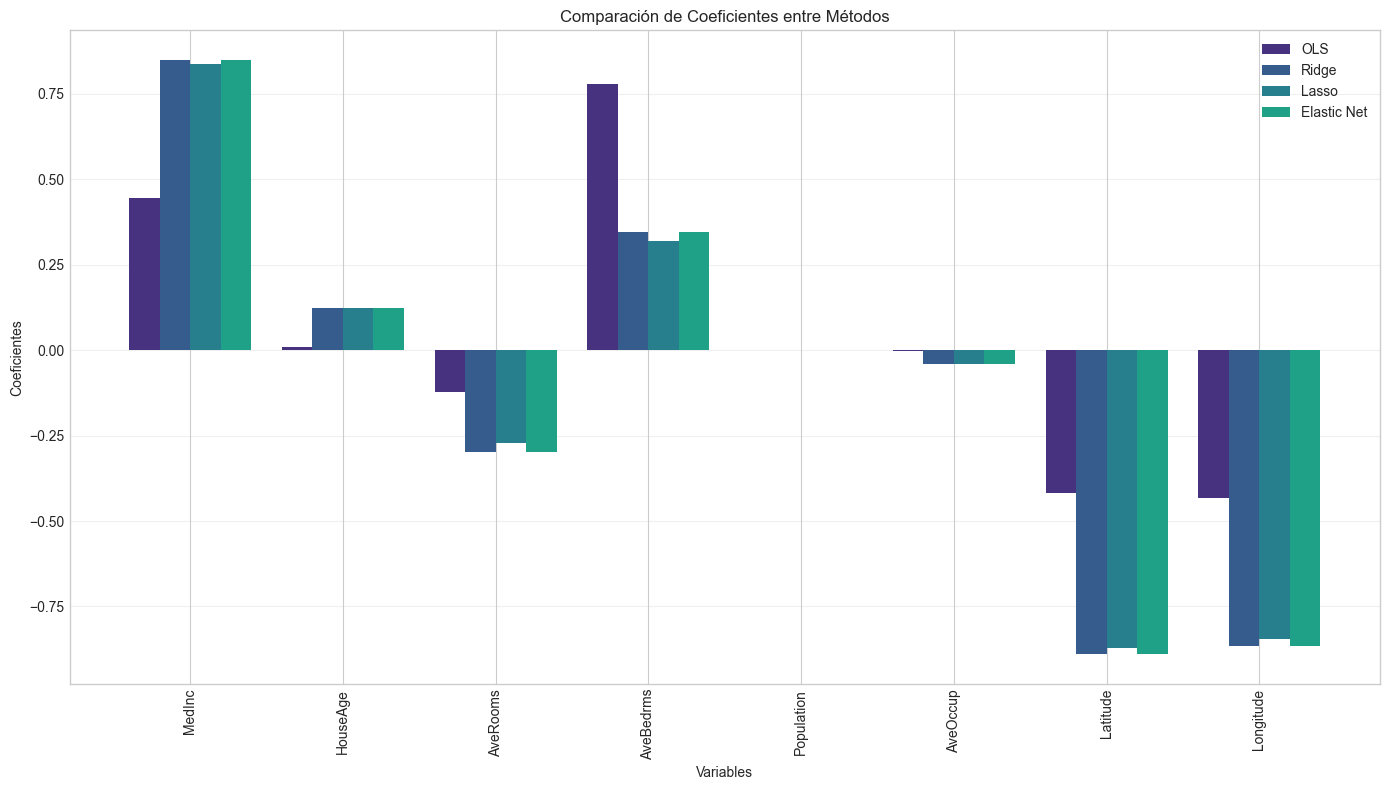


Coeficientes ordenados por magnitud (valor absoluto):

Importancia de variables en OLS:
      Feature           OLS
4   AveBedrms  7.785996e-01
1      MedInc  4.458226e-01
8   Longitude -4.336880e-01
7    Latitude -4.185367e-01
3    AveRooms -1.220951e-01
2    HouseAge  9.681868e-03
6    AveOccup -3.370027e-03
5  Population -7.757404e-07

Importancia de variables en Ridge:
      Feature     Ridge
7    Latitude -0.889753
8   Longitude -0.864456
1      MedInc  0.848884
4   AveBedrms  0.346927
3    AveRooms -0.298355
2    HouseAge  0.122548
6    AveOccup -0.041719
5  Population -0.000739

Importancia de variables en Lasso:
      Feature     Lasso
7    Latitude -0.872361
8   Longitude -0.845576
1      MedInc  0.838041
4   AveBedrms  0.319643
3    AveRooms -0.271045
2    HouseAge  0.123200
6    AveOccup -0.039595
5  Population  0.000000

Importancia de variables en Elastic Net:
      Feature  Elastic_Net
7    Latitude    -0.890277
8   Longitude    -0.864986
1      MedInc     0.848919
4   A

In [10]:
from sklearn.datasets import fetch_california_housing

# Cargamos los datos de California Housing
california = fetch_california_housing()
X, y = california.data, california.target
feature_names = california.feature_names

print("Información del dataset:")
print(f"Número de muestras: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")
print(f"Nombres de características: {feature_names}")

# Convertimos a DataFrame para mejor manejo
df = pd.DataFrame(X, columns=feature_names)
df['PRICE'] = y

# Verificamos las correlaciones entre predictores
corr_matrix = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

# Calculamos VIF para detectar multicolinealidad
vif_data = pd.DataFrame()
vif_data["Feature"] = feature_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print("Factores de Inflación de la Varianza (VIF):")
print(vif_data.sort_values('VIF', ascending=False))

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Añadimos intercepto a las matrices de diseño
X_train_int = np.column_stack((np.ones(X_train.shape[0]), X_train))
X_test_int = np.column_stack((np.ones(X_test.shape[0]), X_test))

# 1. Ajustamos modelo OLS
model_ols = sm.OLS(y_train, X_train_int).fit()
print("\nResumen del modelo OLS:")
print(model_ols.summary().tables[1])

# Evaluamos rendimiento en test
y_pred_ols = X_test_int @ model_ols.params
mse_ols_test = mean_squared_error(y_test, y_pred_ols)
r2_ols_test = r2_score(y_test, y_pred_ols)

print(f"MSE OLS (test): {mse_ols_test:.4f}")
print(f"R² OLS (test): {r2_ols_test:.4f}")

# 2. Probamos diferentes valores de lambda para Ridge, Lasso y Elastic Net
lambda_range = np.logspace(-3, 2, 20)

# Estandarizamos los datos para comparabilidad
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Matrices con intercepto
X_train_std_int = np.column_stack((np.ones(X_train_std.shape[0]), X_train_std))
X_test_std_int = np.column_stack((np.ones(X_test_std.shape[0]), X_test_std))

# Evaluación con validación cruzada
def evaluate_model_cv(model_func, X, y, lambdas, cv=5, **kwargs):
    """Evalúa un modelo para diferentes valores de lambda usando validación cruzada."""
    mean_scores = []
    std_scores = []

    for lambda_val in lambdas:
        scores = []
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X):
            X_cv_train, X_cv_val = X[train_idx], X[val_idx]
            y_cv_train, y_cv_val = y[train_idx], y[val_idx]

            # Añadimos intercepto
            X_cv_train_int = np.column_stack((np.ones(X_cv_train.shape[0]), X_cv_train))
            X_cv_val_int = np.column_stack((np.ones(X_cv_val.shape[0]), X_cv_val))

            # Ajustamos el modelo
            beta = model_func(X_cv_train_int, y_cv_train, lambda_val, **kwargs)

            # Evaluamos
            y_pred = X_cv_val_int @ beta
            mse = mean_squared_error(y_cv_val, y_pred)
            scores.append(mse)

        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    return np.array(mean_scores), np.array(std_scores)

# Evaluamos los tres modelos con validación cruzada
mse_ridge_cv, std_ridge_cv = evaluate_model_cv(ridge_regression, X_train_std, y_train, lambda_range)
mse_lasso_cv, std_lasso_cv = evaluate_model_cv(lasso_coordinate_descent, X_train_std, y_train, lambda_range)
mse_elastic_cv, std_elastic_cv = evaluate_model_cv(elastic_net_coordinate_descent, X_train_std, y_train, 
                                                  lambda_range, alpha=0.5)

# Visualizamos resultados de la validación cruzada
plt.figure(figsize=(12, 6))
plt.errorbar(np.log10(lambda_range), mse_ridge_cv, yerr=std_ridge_cv, fmt='o-', linewidth=2, 
             label='Ridge')
plt.errorbar(np.log10(lambda_range), mse_lasso_cv, yerr=std_lasso_cv, fmt='^--', linewidth=2, 
             label='Lasso')
plt.errorbar(np.log10(lambda_range), mse_elastic_cv, yerr=std_elastic_cv, fmt='s-.', linewidth=2, 
             label='Elastic Net (α=0.5)')
plt.axhline(y=np.mean(cross_val_score(LinearRegression(), X_train_std, y_train, 
                                       cv=5, scoring='neg_mean_squared_error') * -1), 
            color='r', linestyle='--', label='OLS (CV)')
plt.xlabel('Log10(lambda)')
plt.ylabel('MSE (Validación Cruzada)')
plt.title('Comparación de Métodos de Regularización - Validación Cruzada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Encontramos los mejores valores de lambda
best_lambda_ridge = lambda_range[np.argmin(mse_ridge_cv)]
best_lambda_lasso = lambda_range[np.argmin(mse_lasso_cv)]
best_lambda_elastic = lambda_range[np.argmin(mse_elastic_cv)]

print(f"Mejor lambda para Ridge: {best_lambda_ridge:.6f}")
print(f"Mejor lambda para Lasso: {best_lambda_lasso:.6f}")
print(f"Mejor lambda para Elastic Net: {best_lambda_elastic:.6f}")

# Ajustamos los modelos con los mejores lambdas en todos los datos de entrenamiento
beta_ridge_best = ridge_regression(X_train_std_int, y_train, best_lambda_ridge)
beta_lasso_best = lasso_coordinate_descent(X_train_std_int, y_train, best_lambda_lasso)
beta_elastic_best = elastic_net_coordinate_descent(X_train_std_int, y_train, best_lambda_elastic, alpha=0.5)

# Evaluamos en el conjunto de prueba
y_pred_ridge = X_test_std_int @ beta_ridge_best
y_pred_lasso = X_test_std_int @ beta_lasso_best
y_pred_elastic = X_test_std_int @ beta_elastic_best

mse_ridge_test = mean_squared_error(y_test, y_pred_ridge)
mse_lasso_test = mean_squared_error(y_test, y_pred_lasso)
mse_elastic_test = mean_squared_error(y_test, y_pred_elastic)

r2_ridge_test = r2_score(y_test, y_pred_ridge)
r2_lasso_test = r2_score(y_test, y_pred_lasso)
r2_elastic_test = r2_score(y_test, y_pred_elastic)

print("\nResultados en el conjunto de prueba:")
print(f"MSE Ridge: {mse_ridge_test:.4f}, R²: {r2_ridge_test:.4f}")
print(f"MSE Lasso: {mse_lasso_test:.4f}, R²: {r2_lasso_test:.4f}")
print(f"MSE Elastic Net: {mse_elastic_test:.4f}, R²: {r2_elastic_test:.4f}")
print(f"MSE OLS: {mse_ols_test:.4f}, R²: {r2_ols_test:.4f}")

# Comparamos los coeficientes de los diferentes modelos
coef_data = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': model_ols.params,
    'Ridge': beta_ridge_best,
    'Lasso': beta_lasso_best,
    'Elastic_Net': beta_elastic_best
})

print("\nComparación de coeficientes:")
print(coef_data)

# Visualizamos los coeficientes normalizados (excluyendo el intercepto)
plt.figure(figsize=(14, 8))
coef_data_plot = coef_data.copy()
coef_data_plot = coef_data_plot.iloc[1:]  # Excluimos el intercepto

# Visualizamos los coeficientes para cada método por separado
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.bar(coef_data_plot['Feature'], coef_data_plot['OLS'])
plt.title('Coeficientes OLS')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 2, 2)
plt.bar(coef_data_plot['Feature'], coef_data_plot['Ridge'])
plt.title(f'Coeficientes Ridge (λ={best_lambda_ridge:.6f})')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 2, 3)
plt.bar(coef_data_plot['Feature'], coef_data_plot['Lasso'])
plt.title(f'Coeficientes Lasso (λ={best_lambda_lasso:.6f})')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 2, 4)
plt.bar(coef_data_plot['Feature'], coef_data_plot['Elastic_Net'])
plt.title(f'Coeficientes Elastic Net (λ={best_lambda_elastic:.6f}, α=0.5)')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculamos cuántas variables selecciona cada método (coeficientes no cero)
zero_threshold = 1e-6  # Umbral para considerar un coeficiente como cero
print("\nSelección de variables (número de coeficientes no cero, excluyendo intercepto):")
print(f"OLS: {np.sum(np.abs(model_ols.params[1:]) > zero_threshold)} de {len(feature_names)}")
print(f"Ridge: {np.sum(np.abs(beta_ridge_best[1:]) > zero_threshold)} de {len(feature_names)}")
print(f"Lasso: {np.sum(np.abs(beta_lasso_best[1:]) > zero_threshold)} de {len(feature_names)}")
print(f"Elastic Net: {np.sum(np.abs(beta_elastic_best[1:]) > zero_threshold)} de {len(feature_names)}")

# Visualizamos los coeficientes en conjunto para comparar
plt.figure(figsize=(14, 8))
width = 0.2
indices = np.arange(len(feature_names))

plt.bar(indices - 1.5*width, coef_data_plot['OLS'], width, label='OLS')
plt.bar(indices - 0.5*width, coef_data_plot['Ridge'], width, label='Ridge')
plt.bar(indices + 0.5*width, coef_data_plot['Lasso'], width, label='Lasso')
plt.bar(indices + 1.5*width, coef_data_plot['Elastic_Net'], width, label='Elastic Net')

plt.xlabel('Variables')
plt.ylabel('Coeficientes')
plt.title('Comparación de Coeficientes entre Métodos')
plt.xticks(indices, coef_data_plot['Feature'], rotation=90)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis de la importancia de las variables en cada modelo
print("\nCoeficientes ordenados por magnitud (valor absoluto):")

# OLS
ols_importance = coef_data.iloc[1:].copy()  # Excluyendo el intercepto
ols_importance['OLS_abs'] = np.abs(ols_importance['OLS'])
ols_sorted = ols_importance.sort_values('OLS_abs', ascending=False)[['Feature', 'OLS']]
print("\nImportancia de variables en OLS:")
print(ols_sorted)

# Ridge
ridge_importance = coef_data.iloc[1:].copy()
ridge_importance['Ridge_abs'] = np.abs(ridge_importance['Ridge'])
ridge_sorted = ridge_importance.sort_values('Ridge_abs', ascending=False)[['Feature', 'Ridge']]
print("\nImportancia de variables en Ridge:")
print(ridge_sorted)

# Lasso
lasso_importance = coef_data.iloc[1:].copy()
lasso_importance['Lasso_abs'] = np.abs(lasso_importance['Lasso'])
lasso_sorted = lasso_importance.sort_values('Lasso_abs', ascending=False)[['Feature', 'Lasso']]
print("\nImportancia de variables en Lasso:")
print(lasso_sorted)

# Elastic Net
elastic_importance = coef_data.iloc[1:].copy()
elastic_importance['Elastic_abs'] = np.abs(elastic_importance['Elastic_Net'])
elastic_sorted = elastic_importance.sort_values('Elastic_abs', ascending=False)[['Feature', 'Elastic_Net']]
print("\nImportancia de variables en Elastic Net:")
print(elastic_sorted)


## 6. Impacto en la Interpretación de Coeficientes

Uno de los aspectos más importantes al utilizar métodos de regularización es entender cómo afectan a la interpretación de los coeficientes del modelo. Esta sección explora estas implicaciones.

### 6.1 Sesgo de los Estimadores Regularizados

Los métodos de regularización como Ridge, Lasso y Elastic Net introducen un sesgo intencionado en los estimadores para reducir su varianza. Esto tiene consecuencias importantes para la interpretación:

1. **Los coeficientes ya no son insesgados**: A diferencia de OLS, que produce estimadores insesgados bajo los supuestos del modelo lineal, los estimadores regularizados están sesgados. El valor esperado de los coeficientes ya no es igual al verdadero valor poblacional.

2. **Magnitud reducida**: Los coeficientes tienden a ser más pequeños en magnitud que sus contrapartes OLS, lo que puede llevar a subestimar el efecto real de las variables.

3. **Significancia estadística**: Las pruebas de hipótesis estándar (como las pruebas t) no son directamente aplicables a los coeficientes regularizados, ya que su distribución cambia.

### 6.2 Interpretación de Coeficientes Estandarizados

Cuando trabajamos con variables estandarizadas, los coeficientes representan el cambio en la variable respuesta (en unidades de desviación estándar) cuando el predictor cambia en una desviación estándar. Esto facilita la comparación de la importancia relativa de las variables.

### 6.3 Selección de Variables con Lasso

Lasso puede producir coeficientes exactamente iguales a cero, lo que equivale a una selección automática de variables. Esto simplifica la interpretación al identificar un subconjunto de variables clave, pero puede llevar a:

- **Selección inconsistente**: Con muestras diferentes, Lasso puede seleccionar diferentes subconjuntos de variables, especialmente cuando hay alta correlación entre predictores.

- **Omitir variables relevantes**: Si hay un grupo de variables altamente correlacionadas, Lasso tiende a seleccionar solo una de ellas, incluso si varias son relevantes.

### 6.4 Dilema Sesgo-Varianza en la Interpretación

El dilema sesgo-varianza es central para entender los métodos de regularización:

- **OLS**: Bajo sesgo pero alta varianza, lo que puede llevar a coeficientes muy inestables.
- **Ridge/Lasso/Elastic Net**: Mayor sesgo pero menor varianza, lo que produce coeficientes más estables pero potencialmente alejados de los valores reales.

### 6.5 Recomendaciones para la Interpretación de Modelos Regularizados

1. **No interpretar literalmente la magnitud de los coeficientes**: Los coeficientes regularizados estarán generalmente sesgados hacia cero.

2. **Enfocarse en la dirección y la importancia relativa**: El signo de los coeficientes y su orden de magnitud relativa suelen ser más fiables que su valor exacto.

3. **Considerar los intervalos de confianza**: Para Ridge, es posible calcular intervalos de confianza modificados que tengan en cuenta el sesgo, aunque esto es menos común en la práctica.

4. **Utilizar métodos de remuestreo**: El bootstrap puede proporcionar información sobre la estabilidad de los coeficientes.

5. **Comparar con OLS cuando sea posible**: Si la multicolinealidad no es severa, comparar con OLS puede ayudar a entender el efecto de la regularización.

6. **Para Lasso, considerar la trayectoria completa**: Observar cómo cambian los coeficientes a lo largo de diferentes valores de λ puede proporcionar información valiosa sobre la estabilidad de la selección de variables.

Vamos a ilustrar algunos de estos conceptos con visualizaciones:


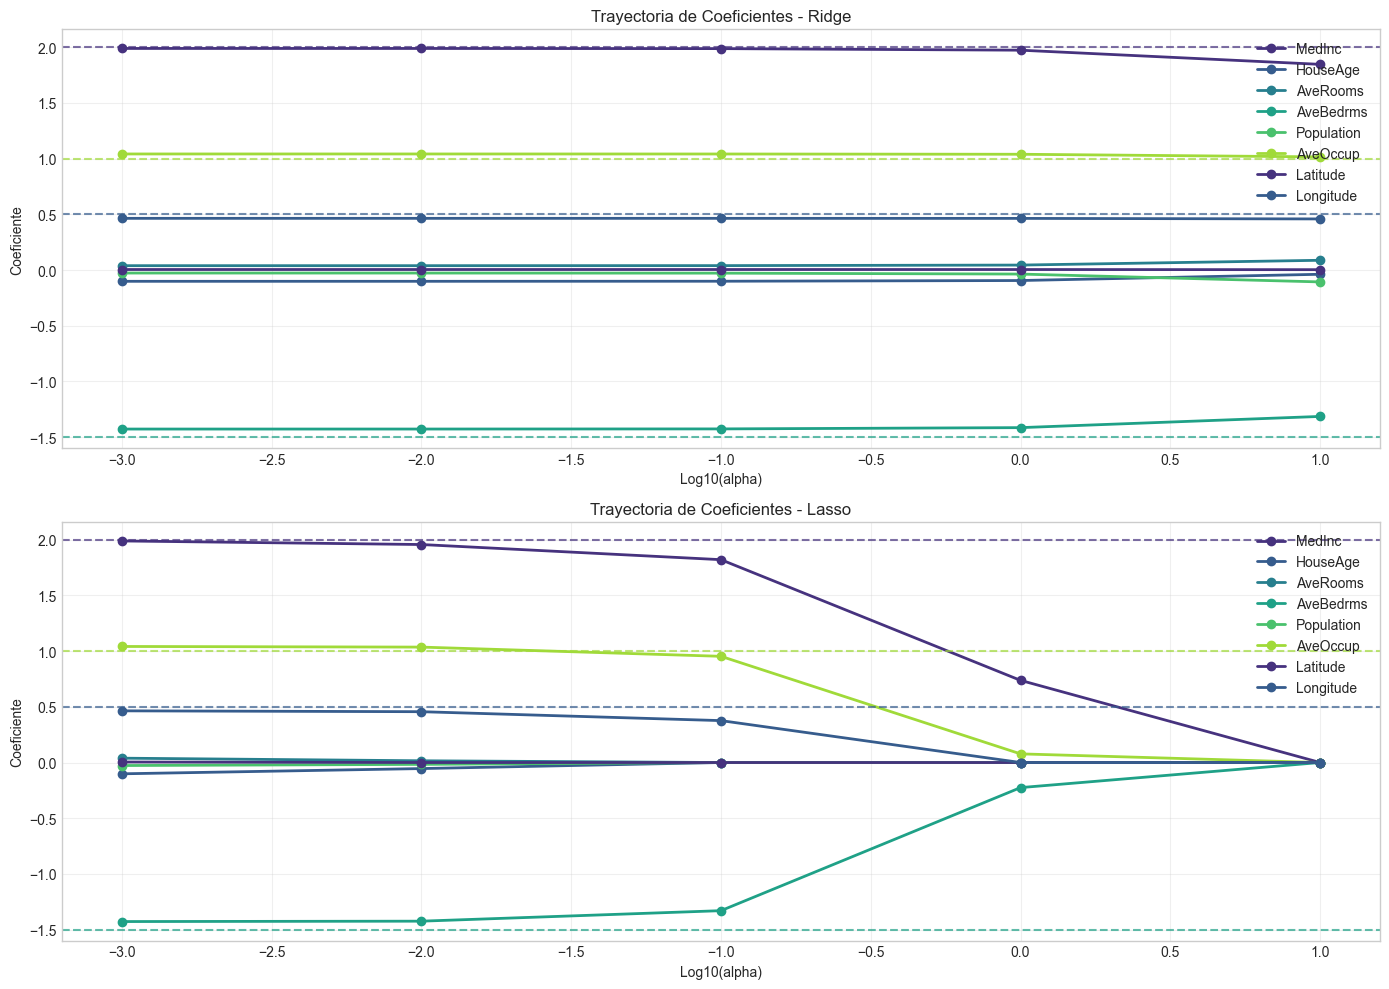

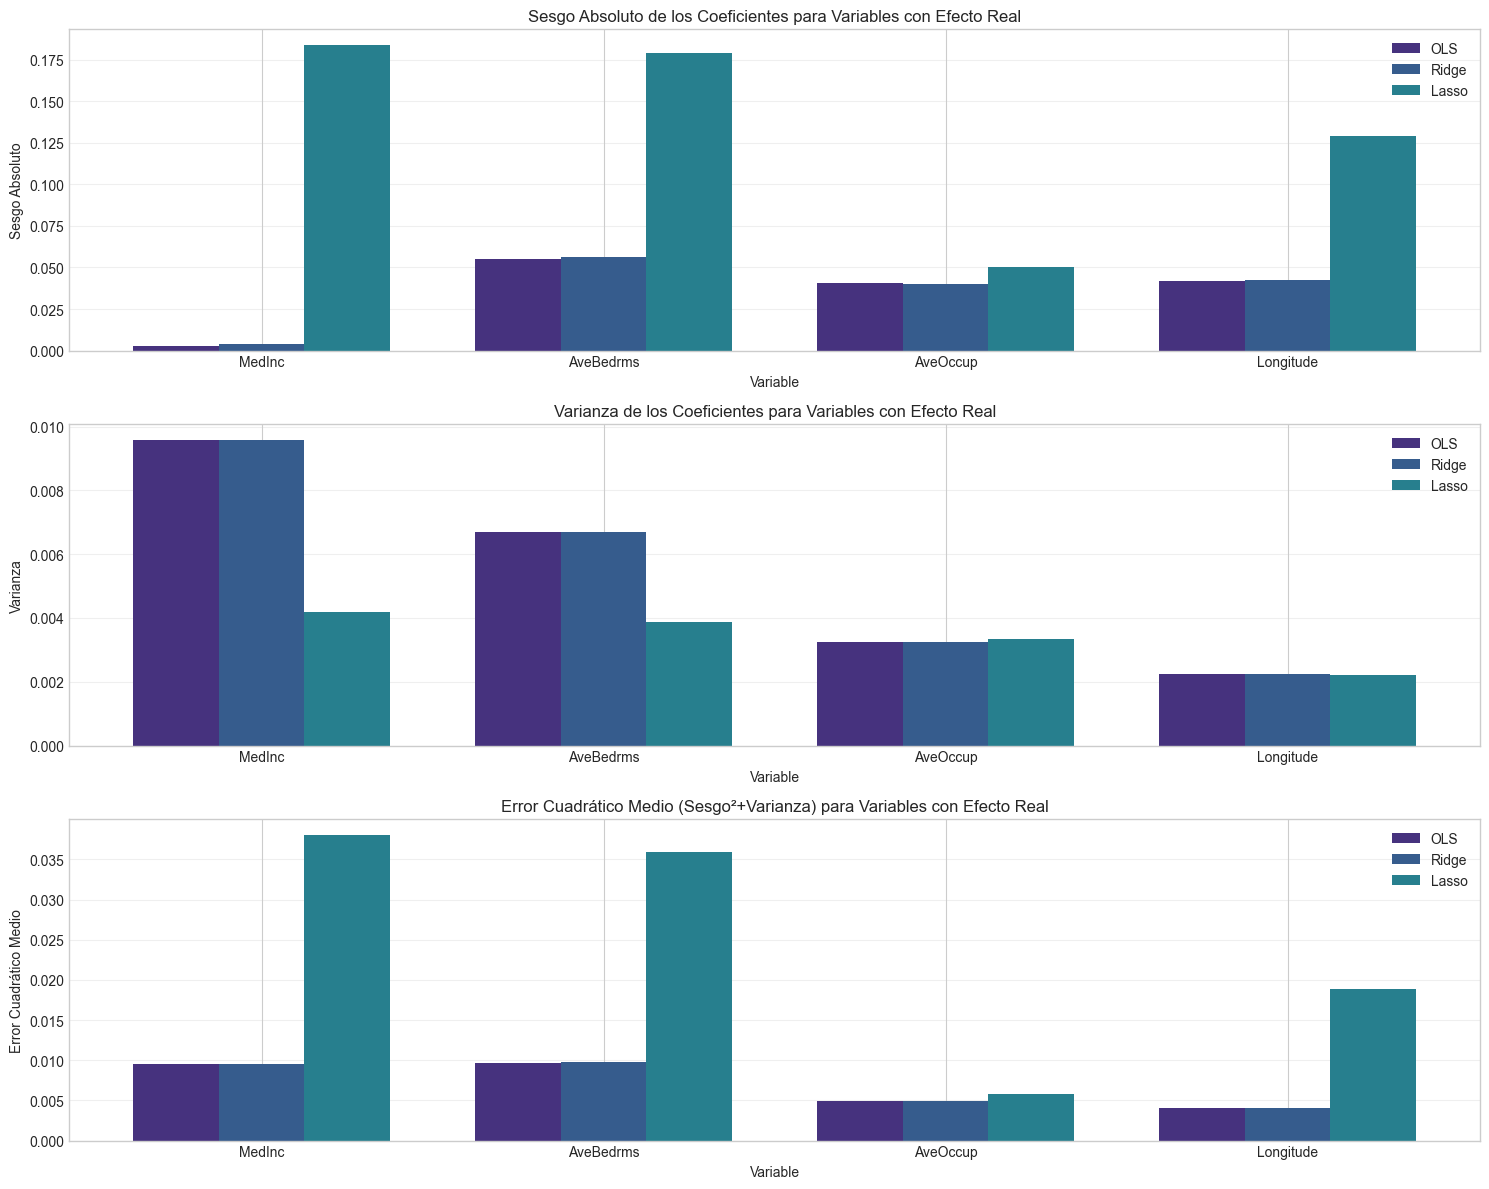

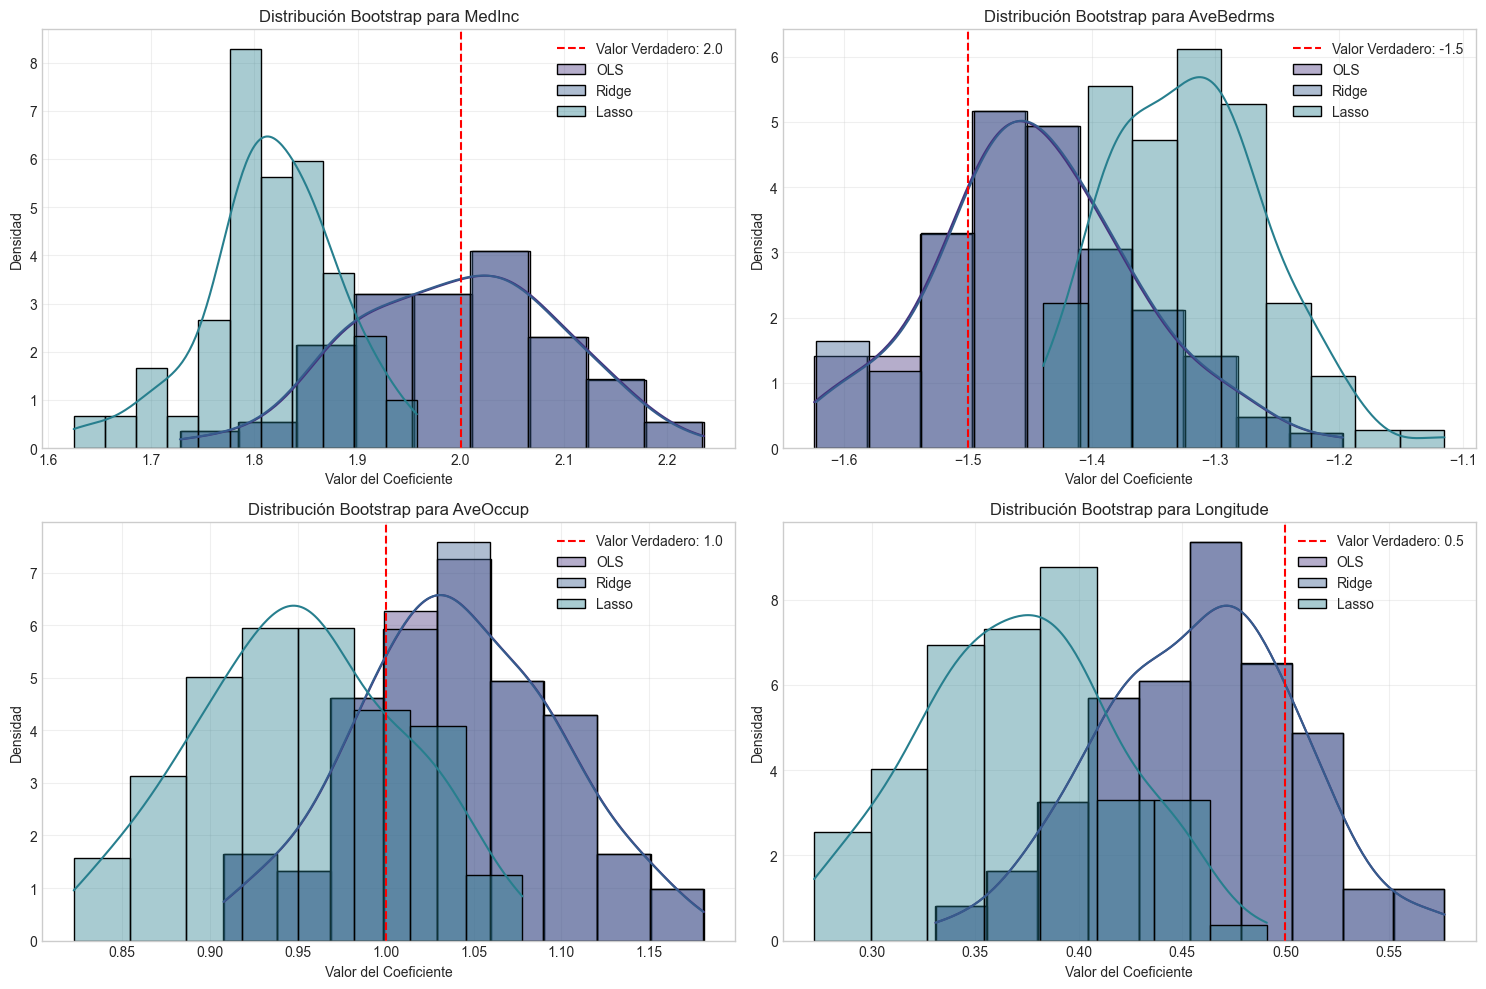

In [11]:
# Simulamos un ejemplo para visualizar el impacto en la interpretación

# Generamos datos con multicolinealidad controlada
np.random.seed(123)
n = 500
p = 8  # Número de predictores (igual al número de características en California Housing)

# Matriz de correlación con bloques correlacionados
Sigma = np.eye(p)
# Simulamos correlaciones similares a las que podríamos encontrar en datos reales
# Bloque 1: Variables 0, 1, 2 correlacionadas (como características geográficas)
Sigma[0, 1] = Sigma[1, 0] = 0.75
Sigma[0, 2] = Sigma[2, 0] = 0.65
Sigma[1, 2] = Sigma[2, 1] = 0.70
# Bloque 2: Variables 3, 4 correlacionadas (como características demográficas)
Sigma[3, 4] = Sigma[4, 3] = 0.80

# Generamos datos multivariados normales
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

# Coeficientes verdaderos - solo algunos tienen efecto real
beta_true = np.zeros(p)
beta_true[[0, 3, 5, 7]] = [2.0, -1.5, 1.0, 0.5]  # Solo 4 variables tienen efecto

# Variable respuesta con ruido
y = X @ beta_true + np.random.normal(0, 1, n)

# Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Asignamos nombres similares a los de California Housing para mayor contexto
feature_names_sim = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

# Ajustamos modelos con diferentes grados de regularización
# Para este ejemplo, usamos scikit-learn para mayor simplicidad
alphas = [0, 0.01, 0.1, 1.0, 10.0]
ridge_models = [Ridge(alpha=alpha, fit_intercept=True).fit(X_train, y_train) for alpha in alphas]
lasso_models = [Lasso(alpha=alpha, fit_intercept=True, max_iter=10000).fit(X_train, y_train) for alpha in alphas]

# Recopilamos los coeficientes para cada modelo
ridge_coefs = np.array([model.coef_ for model in ridge_models])
lasso_coefs = np.array([model.coef_ for model in lasso_models])

# Visualizamos las trayectorias de coeficientes
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
for i in range(p):
    plt.plot(np.log10([0.001 if x==0 else x for x in alphas]), ridge_coefs[:, i], '-o', linewidth=2, 
             label=f'{feature_names_sim[i]}')

# Añadimos líneas horizontales para los coeficientes verdaderos
for i, b in enumerate(beta_true):
    if b != 0:
        plt.axhline(y=b, color=plt.gca().lines[i].get_color(), linestyle='--', alpha=0.7)

plt.xlabel('Log10(alpha)')
plt.ylabel('Coeficiente')
plt.title('Trayectoria de Coeficientes - Ridge')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
for i in range(p):
    plt.plot(np.log10([0.001 if x==0 else x for x in alphas]), lasso_coefs[:, i], '-o', linewidth=2, 
             label=f'{feature_names_sim[i]}')

# Añadimos líneas horizontales para los coeficientes verdaderos
for i, b in enumerate(beta_true):
    if b != 0:
        plt.axhline(y=b, color=plt.gca().lines[i].get_color(), linestyle='--', alpha=0.7)

plt.xlabel('Log10(alpha)')
plt.ylabel('Coeficiente')
plt.title('Trayectoria de Coeficientes - Lasso')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Visualizamos sesgo vs varianza
# Realizamos simulaciones bootstrap para estimar la variabilidad de los coeficientes
n_bootstrap = 100
bootstrap_ols_coefs = np.zeros((n_bootstrap, p))
bootstrap_ridge_coefs = np.zeros((n_bootstrap, p))
bootstrap_lasso_coefs = np.zeros((n_bootstrap, p))

# Elegimos un valor de alpha intermedio para Ridge y Lasso
alpha_ridge = 0.1
alpha_lasso = 0.1

for i in range(n_bootstrap):
    # Muestreamos con reemplazo
    indices = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    X_boot, y_boot = X_train[indices], y_train[indices]

    # Ajustamos los modelos
    model_ols = LinearRegression().fit(X_boot, y_boot)
    model_ridge = Ridge(alpha=alpha_ridge).fit(X_boot, y_boot)
    model_lasso = Lasso(alpha=alpha_lasso, max_iter=10000).fit(X_boot, y_boot)

    # Guardamos los coeficientes
    bootstrap_ols_coefs[i] = model_ols.coef_
    bootstrap_ridge_coefs[i] = model_ridge.coef_
    bootstrap_lasso_coefs[i] = model_lasso.coef_

# Calculamos sesgo y varianza para cada método
# Sesgo = Promedio de los coeficientes - Coeficiente verdadero
bias_ols = np.mean(bootstrap_ols_coefs, axis=0) - beta_true
bias_ridge = np.mean(bootstrap_ridge_coefs, axis=0) - beta_true
bias_lasso = np.mean(bootstrap_lasso_coefs, axis=0) - beta_true

# Varianza = Varianza de los coeficientes a lo largo de las simulaciones bootstrap
var_ols = np.var(bootstrap_ols_coefs, axis=0)
var_ridge = np.var(bootstrap_ridge_coefs, axis=0)
var_lasso = np.var(bootstrap_lasso_coefs, axis=0)

# Error Cuadrático Medio = Sesgo^2 + Varianza
mse_ols = bias_ols**2 + var_ols
mse_ridge = bias_ridge**2 + var_ridge
mse_lasso = bias_lasso**2 + var_lasso

# Visualizamos los resultados para coeficientes con efecto real
variables_con_efecto = [0, 3, 5, 7]  # Índices de las variables con efecto real
nombres_con_efecto = [feature_names_sim[i] for i in variables_con_efecto]

plt.figure(figsize=(15, 12))

# Sesgo
plt.subplot(3, 1, 1)
bar_width = 0.25
positions = np.arange(len(variables_con_efecto))

plt.bar(positions - bar_width, np.abs(bias_ols[variables_con_efecto]), bar_width, label='OLS')
plt.bar(positions, np.abs(bias_ridge[variables_con_efecto]), bar_width, label='Ridge')
plt.bar(positions + bar_width, np.abs(bias_lasso[variables_con_efecto]), bar_width, label='Lasso')

plt.xlabel('Variable')
plt.ylabel('Sesgo Absoluto')
plt.title('Sesgo Absoluto de los Coeficientes para Variables con Efecto Real')
plt.xticks(positions, nombres_con_efecto)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Varianza
plt.subplot(3, 1, 2)
plt.bar(positions - bar_width, var_ols[variables_con_efecto], bar_width, label='OLS')
plt.bar(positions, var_ridge[variables_con_efecto], bar_width, label='Ridge')
plt.bar(positions + bar_width, var_lasso[variables_con_efecto], bar_width, label='Lasso')

plt.xlabel('Variable')
plt.ylabel('Varianza')
plt.title('Varianza de los Coeficientes para Variables con Efecto Real')
plt.xticks(positions, nombres_con_efecto)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Error Cuadrático Medio
plt.subplot(3, 1, 3)
plt.bar(positions - bar_width, mse_ols[variables_con_efecto], bar_width, label='OLS')
plt.bar(positions, mse_ridge[variables_con_efecto], bar_width, label='Ridge')
plt.bar(positions + bar_width, mse_lasso[variables_con_efecto], bar_width, label='Lasso')

plt.xlabel('Variable')
plt.ylabel('Error Cuadrático Medio')
plt.title('Error Cuadrático Medio (Sesgo²+Varianza) para Variables con Efecto Real')
plt.xticks(positions, nombres_con_efecto)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Visualizamos distribuciones bootstrap para algunos coeficientes
plt.figure(figsize=(15, 10))

for i, var_idx in enumerate(variables_con_efecto):
    plt.subplot(2, 2, i+1)

    # Creamos histogramas para los tres métodos
    sns.histplot(bootstrap_ols_coefs[:, var_idx], kde=True, stat='density', alpha=0.4, label='OLS')
    sns.histplot(bootstrap_ridge_coefs[:, var_idx], kde=True, stat='density', alpha=0.4, label='Ridge')
    sns.histplot(bootstrap_lasso_coefs[:, var_idx], kde=True, stat='density', alpha=0.4, label='Lasso')

    # Añadimos línea vertical para el valor verdadero
    plt.axvline(x=beta_true[var_idx], color='red', linestyle='--', 
                label=f'Valor Verdadero: {beta_true[var_idx]}')

    plt.xlabel('Valor del Coeficiente')
    plt.ylabel('Densidad')
    plt.title(f'Distribución Bootstrap para {feature_names_sim[var_idx]}')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Ejercicios Prácticos

A continuación, se presentan una serie de ejercicios prácticos para reforzar los conceptos aprendidos en este taller sobre soluciones a la multicolinealidad.

### Ejercicio 1: Diagnóstico y Corrección de Multicolinealidad

Utiliza el siguiente conjunto de datos sintéticos para:

1. Identificar la presencia de multicolinealidad mediante VIF y la matriz de correlación.
2. Aplicar centrado y estandarización y evaluar si se reduce la multicolinealidad.
3. Implementar Ridge, Lasso y Elastic Net con diferentes valores de λ.
4. Comparar los resultados de los modelos en términos de MSE y R².

```python
# Código para generar los datos
np.random.seed(456)
n = 200
x1 = np.random.normal(0, 1, n)
x2 = 0.8 * x1 + 0.2 * np.random.normal(0, 1, n)  # Correlacionada con x1
x3 = 0.7 * x1 + 0.3 * np.random.normal(0, 1, n)  # Correlacionada con x1
x4 = np.random.normal(0, 1, n)
x5 = x4 + 0.1 * np.random.normal(0, 1, n)  # Correlacionada con x4

X = np.column_stack((x1, x2, x3, x4, x5))
beta_true = np.array([3, 0, 2, 1, 0])
y = X @ beta_true + np.random.normal(0, 1, n)
```

### Ejercicio 2: Efecto de la Regularización en Términos Polinómicos

En este ejercicio, explorarás cómo la multicolinealidad afecta a los modelos con términos polinómicos y cómo la regularización puede ayudar.

1. Genera datos donde la variable y depende de manera polinómica de x (por ejemplo, y = 1 + 2x - 0.5x² + ε).
2. Ajusta modelos de regresión polinómica de diferentes grados (1 a 5) sin regularización.
3. Aplica Ridge y Lasso a los modelos polinómicos y compara los resultados.
4. Visualiza los resultados y comenta sobre el sobreajuste y la multicolinealidad.

### Ejercicio 3: Selección Automática de Variables con Lasso

En este ejercicio, utilizarás Lasso para la selección automática de variables en un contexto con muchas variables irrelevantes.

1. Genera un conjunto de datos con 30 variables, donde solo 5 tienen un efecto real sobre y.
2. Ajusta un modelo Lasso con validación cruzada para seleccionar el mejor valor de λ.
3. Identifica qué variables selecciona Lasso y compáralas con las que realmente tienen efecto.
4. Comenta sobre la precisión de la selección y los falsos positivos/negativos.

### Ejercicio 4: Comparación con el Dataset de California Housing

En este ejercicio, aplicarás lo aprendido al conjunto de datos de California Housing que se utilizó en el caso práctico:

1. Crea términos polinómicos e interacciones para este conjunto de datos, lo que incrementará la multicolinealidad.
2. Analiza cómo cambia el VIF al añadir estos nuevos términos.
3. Aplica Ridge, Lasso y Elastic Net para contrarrestar la multicolinealidad.
4. Compara el rendimiento predictivo de los modelos con validación cruzada.

```python
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures

# Carga los datos
california = fetch_california_housing()
X, y = california.data, california.target

# Crea términos polinómicos de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Implementa tu análisis aquí...
```

### Ejercicio 5: Comparación de Estabilidad de Coeficientes

En este ejercicio, investigarás la estabilidad de los coeficientes bajo diferentes métodos de regularización.

1. Utiliza bootstrap para generar múltiples muestras de un conjunto de datos con multicolinealidad.
2. Para cada muestra, ajusta modelos OLS, Ridge, Lasso y Elastic Net.
3. Calcula la variabilidad de los coeficientes para cada método.
4. Visualiza y comenta sobre las diferencias en estabilidad entre los métodos.

### Bonus: Implementación Eficiente de Path Algoritmico para Lasso

Implementa el algoritmo de trayectoria completa para Lasso (LARS - Least Angle Regression) que calcula los coeficientes para todos los valores posibles de λ de manera eficiente.

```python
def lasso_path(X, y, max_features=None, eps=1e-6):
    """
    Implementación del algoritmo LARS para calcular la trayectoria de soluciones Lasso.

    Parámetros:
    X : array, matriz de diseño
    y : array, vector de variable respuesta
    max_features : int, número máximo de características a incluir
    eps : float, tolerancia para convergencia

    Retorna:
    alphas : array, valores decrecientes de λ
    coefs : array, matriz con coeficientes para cada valor de λ
    """
    # Tu implementación aquí...
    return alphas, coefs
```


## 8. Referencias Bibliográficas

### Textos fundamentales sobre regresión y regularización

- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer. [Link](https://web.stanford.edu/~hastie/ElemStatLearn/)

- James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). *An Introduction to Statistical Learning with Applications in R*. Springer. [Link](https://www.statlearning.com/)

- Hoerl, A. E., & Kennard, R. W. (1970). Ridge Regression: Biased Estimation for Nonorthogonal Problems. *Technometrics*, 12(1), 55-67.

- Tibshirani, R. (1996). Regression Shrinkage and Selection via the Lasso. *Journal of the Royal Statistical Society. Series B (Methodological)*, 58(1), 267-288.

- Zou, H., & Hastie, T. (2005). Regularization and Variable Selection via the Elastic Net. *Journal of the Royal Statistical Society. Series B (Statistical Methodology)*, 67(2), 301-320.

### Artículos y recursos sobre multicolinealidad

- Belsley, D. A., Kuh, E., & Welsch, R. E. (1980). *Regression Diagnostics: Identifying Influential Data and Sources of Collinearity*. Wiley.

- Marquardt, D. W. (1970). Generalized Inverses, Ridge Regression, Biased Linear Estimation, and Nonlinear Estimation. *Technometrics*, 12(3), 591-612.

- O'Brien, R. M. (2007). A Caution Regarding Rules of Thumb for Variance Inflation Factors. *Quality & Quantity*, 41(5), 673-690.

### Recursos computacionales y de Python

- Scikit-learn: Machine Learning in Python. [Link](https://scikit-learn.org/stable/modules/linear_model.html)

- Friedman, J., Hastie, T., & Tibshirani, R. (2010). Regularization Paths for Generalized Linear Models via Coordinate Descent. *Journal of Statistical Software*, 33(1), 1-22. [Link](https://www.jstatsoft.org/article/view/v033i01)

- Efron, B., Hastie, T., Johnstone, I., & Tibshirani, R. (2004). Least Angle Regression. *The Annals of Statistics*, 32(2), 407-451.

### Otros recursos recomendados

- Kuhn, M., & Johnson, K. (2013). *Applied Predictive Modeling*. Springer.

- Kutner, M. H., Nachtsheim, C. J., Neter, J., & Li, W. (2004). *Applied Linear Statistical Models* (5th ed.). McGraw-Hill/Irwin.

- Fox, J. (2015). *Applied Regression Analysis and Generalized Linear Models* (3rd ed.). SAGE Publications.
